In [120]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import nltk
from gensim import models, corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from collections import Counter, OrderedDict
from gensim.models import KeyedVectors
from gensim.matutils import unitvec
from sklearn.manifold import TSNE
import pickle
import collections
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
import gensim
from gensim.models import TfidfModel
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import sentiwordnet as swn
import gensim.downloader as api

In [110]:
nltk.download('stopwords')
nltk.download('punkt')  # Download the NLTK tokenizer data

# Import dataset
characters_df = pd.read_csv("./dataset/Characters.csv", sep=";")
movie1_df = pd.read_csv("./dataset/Harry Potter 1.csv", sep=";")
movie2_df = pd.read_csv("./dataset/Harry Potter 2.csv", sep=";")
movie3_df = pd.read_csv("./dataset/Harry Potter 3.csv", sep=";")
potions_df = pd.read_csv("./dataset/Potions.csv", sep=";")
other_characters_df = pd.read_csv("./dataset/shortversioncharacters.csv", sep=",")
spells_df = pd.read_csv("./dataset/Spells.csv", sep=";")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/duminduakalanka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/duminduakalanka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
# Analyze characters
class Character():
    def __init__(self, df):
        self.data = df
        f = open("./resources/character_mapping.json", "r")
        self.character_mapping = json.load(f)
        f.close()
        
    def map(self, character_name):
        # Map similar character to a group
        character_name = character_name.strip()
        if character_name in self.character_mapping and self.character_mapping[character_name] is not None:
            return self.character_mapping[character_name].title()
        else:
            return character_name.title()

In [24]:
# Movie
movie1_df['Movie'] = 'Harry Potter and the Sorcerers Stone'
movie2_df['Movie'] = 'Harry Potter and the Chamber of Secrets'
movie3_df['Movie'] = 'Harry Potter and the Prisoner of Azkaban'

movies_list = [movie1_df, movie2_df, movie3_df]

class Movie():
    def __init__(self, df: list):
        self.movie_list = df
        self.movies_df = self.combine_movies()

    def combine_movies(self):
        # Combine movies
        for i in self.movie_list:
            i.columns = map(str.title, i.columns)
        
        return pd.concat([movie1_df, movie2_df, movie3_df], ignore_index=False)
        
    def preprocess(self):
        # Strip the spaces in character to remove identifying the same character twice
        self.movies_df["Character"] = self.movies_df.apply(lambda row: row["Character"].strip().title(), axis=1)


In [25]:
# Preprocess
def preprocessing():
    c = Character(characters_df)
    
    m = Movie(movies_list)
    m.preprocess()

    m.movies_df["Character"] = m.movies_df.apply(lambda row: c.map(row["Character"]), axis=1)

    return c,m

c, m = preprocessing()

In [47]:
grouped = m.movies_df.groupby("Character").count().reset_index()
grouped.sort_values('Sentence', ascending=False)
less_than_comparison = grouped[grouped['Sentence'] < 10]
percentage_less_than = (len(less_than_comparison) / len(grouped)) * 100
percentage_less_than

47.474747474747474

In [48]:
nltk.download("punkt")

def other_char_corpora():
    vocab_size_df = m.movies_df.groupby("Character").sum().reset_index()
    for i,row in vocab_size_df.iterrows():
        words = nltk.word_tokenize(row["Sentence"])
        vocabulary_size = len(set(words))
        grouped.at[i, "vocab_size"] = vocabulary_size
        

other_char_corpora()
grouped = grouped.loc[grouped["Sentence"]>50]
grouped    

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/duminduakalanka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Character  Sentence  Movie  PRP_Count  vocab_size
3        Aunt Petunia        55     55         55       189.0
14              Dobby        69     69         69       238.0
15       Draco Malfoy       131    131        131       386.0
17         Dumbledore       239    239        239       869.0
27              Fudge        65     65         65       250.0
29  Gilderoy Lockhart       113    113        113       424.0
36             Hagrid       394    394        394       914.0
37              Harry      1028   1028       1028      1505.0
40           Hermione       488    488        488       986.0
46      Lucius Malfoy        75     75         75       266.0
47              Lupin       207    207        207       609.0
53         Mcgonagall       152    152        152       552.0
57       Mrs. Weasley        75     75         75       258.0
71                Ron       536    536        536       989.0
78             Sirius        70     70         70       264.0
81              Snape       121    121        121       500.0
88         Tom Riddle        70     70         70       334.0
91       Uncle Vernon        51     51         51       222.0

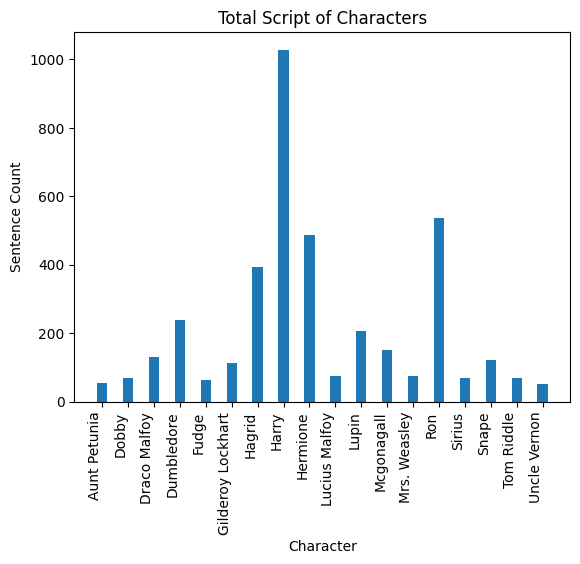

In [49]:
# create histograms for length of total script
def histogram(x):
    pd.Series(x).plot(kind='bar')


plt.bar(grouped["Character"], grouped["Sentence"], width = 0.4)

plt.xticks(rotation=90, ha='right')

# Label the chart
plt.xlabel('Character')
plt.ylabel('Sentence Count')
plt.title('Total Script of Characters')

# Show the chart
plt.show()


In [51]:
# TODO Could not find a list of personal pronouns here. https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
#      Therefore Used nltk pos tags

def countPersonalPronouns(sentence):
    words = nltk.word_tokenize(sentence)

    # Find personal pronouns
    personal_pronouns = [word for word, tag in nltk.pos_tag(words) if tag == 'PRP']

    return len(personal_pronouns)

m.movies_df["PRP_Count"] = m.movies_df.apply(lambda row: countPersonalPronouns(row["Sentence"]), axis=1)
grouped_with_PRP = m.movies_df.groupby("Character").sum().reset_index()
grouped_with_PRP = grouped_with_PRP.loc[grouped_with_PRP["PRP_Count"] > 5]
grouped_with_PRP.sort_values('PRP_Count', ascending=False)

Character                                           Sentence  \
37              Harry  Yes, Aunt Petunia.Yes, Uncle Vernon.He's aslee...   
71                Ron  Excuse me. Do you mind?Everywhere else is full...   
40           Hermione  Has anyone seen a toad?A boy named Neville's l...   
36             Hagrid  Professor Dumbledore, sir.Professor McGonagall...   
17         Dumbledore  I should've known that you would be here, Prof...   
47              Lupin  Here, eat this. It'll help.It's all right. It'...   
53         Mcgonagall  Good evening, Professor Dumbledore.Are the rum...   
15       Draco Malfoy  It's true then, what they're saying on the tra...   
81              Snape  There will be no foolish wand-waving or silly ...   
29  Gilderoy Lockhart  Let me introduce you to your new Defense Again...   
78             Sirius  No. Only one will die tonight.Are you going to...   
88         Tom Riddle  Professor Dumbledore.Yes, professor. I suppose...   
46      Lucius Malfoy  I'm not buying today, Mr. Borgin.But selling.Y...   
91       Uncle Vernon  I’m warning you, if you can’t control that blo...   
57       Mrs. Weasley  It's the same every year, packed with Muggles,...   
3        Aunt Petunia  Up. Get up!Now!Here he comes, the birthday boy...   
27              Fudge  Bad business, Hagrid, very bad business.Had to...   
54     Moaning Myrtle  I'm Moaning Myrtle.I wouldn't expect you to kn...   
19              Filch  Anyone here, my sweet? Come on.Who's there?! I...   
70           Quirrell  Harry Potter. Can't tell you how pleased I am ...   
58            Neville  Trevor! Sorry.That picture's moving.The only p...   
90          Trelawney  Welcome, my children.In this room, you shall e...   
56        Mr. Weasley  Morning, Weasleys.What a night. Nine raids. Ni...   
84      Stan Shunpike  Welcome to the Knight Bus...emergency transpor...   
2          Aunt Marge  You still here, are you?Don't say 'yes' in tha...   
93             Vernon  Happy birthday, son.Hurry up! Bring my coffee,...   
14              Dobby  Ha- ha- ha! Ha, ha! Ho, ho, ho! Ha, ha! Harry ...   
28             George  He's not Fred, I am.Our job is to make sure th...   
95          Voldemort  Use the boyHe lies.Let me speak to him.I have ...   
65              Percy  Oh, thats Professor Snape, head of Slytherin h...   
66          Pettigrew  Remus? Sirius. My old friends!Harry! Look at y...   
23               Fred  Honestly, woman, you call yourself our mother?...   
60             Oliver  Quidditch is easy enough to understand. Each t...   
69   Professor Sprout  Morning, everyone.Good morning, Professor Spro...   
61         Ollivander  I wondered when I'd be seeing you, Mr. Potter....   
73             Seamus  I'm half and half.My dad's a Muggle. Mum's a w...   
48        Madam Hooch  Good afternoon, class.Good afternoon, Amanda.G...   
83        Sorting Hat  Ah, right then... hmm... right.Okay. Gryffindo...   
1              Aragog  Who is it?Hagrid?Is that you?Yes.Hagrid has ne...   
20            Firenze  Harry Potter, you must leave. You are known to...   
16             Dudley  Wake up, cousin!We're going to the zoo!How man...   
98               Wood  I spent the summer devising a whole new Quiddi...   
94              Voice  Come.Come to me.Blood.I smell blood.Let me rip...   
74      Shrunken Head  Yeah, take it away, Ernie.It's going to be a b...   
49      Madam Pomfrey  Mr. Malfoy, stop making such a fuss.You can go...   
30              Ginny  Good luck.Mum- Mummy, have you seen my jumper?...   
97              Witch  Doris Crockford, Mr Potter.I can't believe I'm...   
77       Sir Nicholas  Hello! How are you?Welcome to Gryffindor.Disma...   
50     Madam Rosmerta  It'd be a lot better if the Ministry wasn't se...   
52            Man/Boy  Welcome back, Mr. Potter.Welcome back.It's a w...   

                                                Movie  PRP_Count  
37  Harry Potter and the Sorcerers StoneHarry Pott...        859  
7

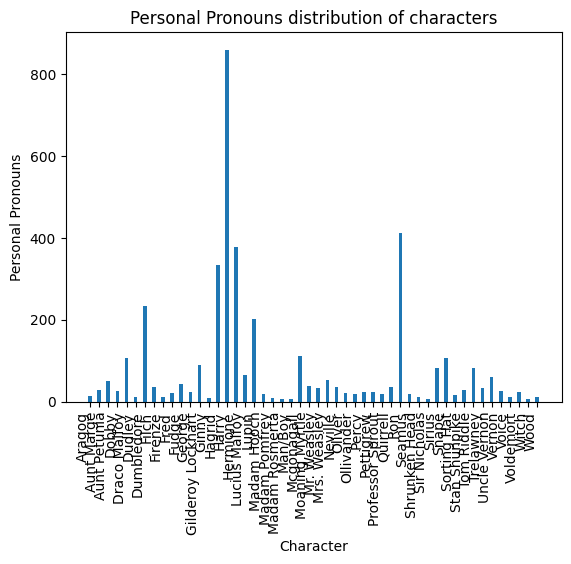

In [31]:
# histogram(grouped_with_PRP["PRP_Count"])

plt.bar(grouped_with_PRP["Character"], grouped_with_PRP["PRP_Count"], width = 0.4)

plt.xticks(rotation=90, ha='right')

# Label the chart
plt.xlabel('Character')
plt.ylabel('Personal Pronouns')
plt.title('Personal Pronouns distribution of characters')

# Show the chart
plt.show()


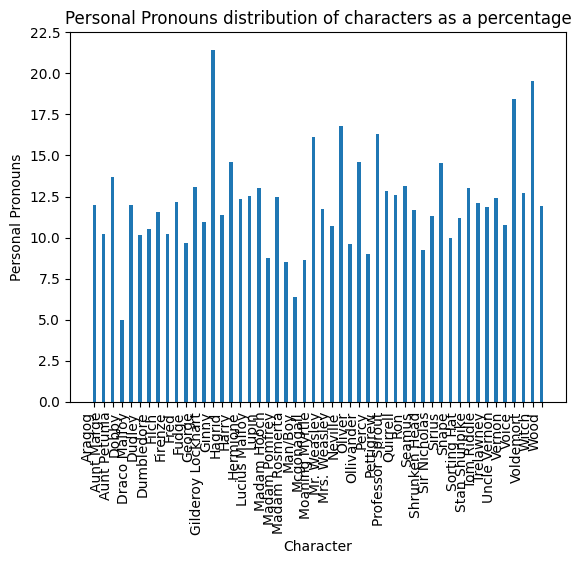

In [53]:
# Personal Pronouns as a percentage
grouped_with_PRP["PRP_Percent"] = grouped_with_PRP.apply(lambda row:row["PRP_Count"]*100/len(nltk.word_tokenize(row["Sentence"])), axis=1)

plt.bar(grouped_with_PRP["Character"], grouped_with_PRP["PRP_Percent"], width = 0.4)

plt.xticks(rotation=90, ha='right')

# Label the chart
plt.xlabel('Character')
plt.ylabel('Personal Pronouns')
plt.title('Personal Pronouns distribution of characters as a percentage')

# Show the chart
plt.show()

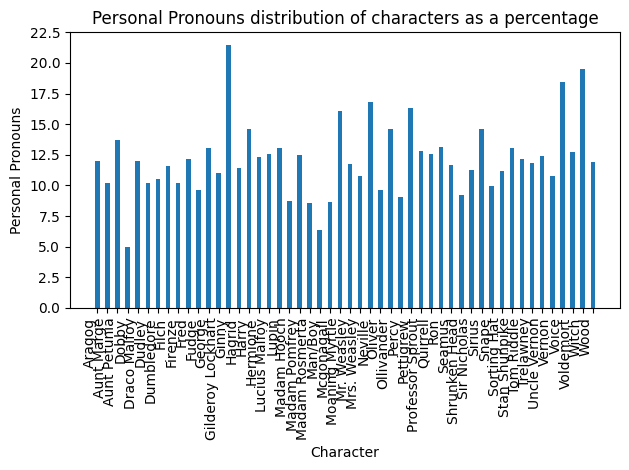

In [55]:
import matplotlib.pyplot as plt

# Your data
character = grouped_with_PRP["Character"]
prp_percent = grouped_with_PRP["PRP_Percent"]

# Increase the space between bars
bar_width = 0.8  # Adjust this value for the width of each bar
bar_spacing = 0.8  # Adjust this value to increase/decrease the space

# Create positions for the bars
x = range(len(character))

# Create the bar plot with increased space
plt.bar([pos + i * bar_spacing for i, pos in enumerate(x)], prp_percent, width=bar_width)

# Set the x-axis labels with adjusted spacing
plt.xticks([pos + i * bar_spacing for i, pos in enumerate(x)], character, rotation=90, ha='right')

# Label the chart
plt.xlabel('Character')
plt.ylabel('Personal Pronouns')
plt.title('Personal Pronouns distribution of characters as a percentage')

# Show the chart
plt.tight_layout()  # This helps improve label spacing
plt.show()


In [57]:
grouped_with_PRP.sort_values('PRP_Percent', ascending=False)

Character                                           Sentence  \
30              Ginny  Good luck.Mum- Mummy, have you seen my jumper?...   
97              Witch  Doris Crockford, Mr Potter.I can't believe I'm...   
94              Voice  Come.Come to me.Blood.I smell blood.Let me rip...   
58            Neville  Trevor! Sorry.That picture's moving.The only p...   
66          Pettigrew  Remus? Sirius. My old friends!Harry! Look at y...   
54     Moaning Myrtle  I'm Moaning Myrtle.I wouldn't expect you to kn...   
61         Ollivander  I wondered when I'd be seeing you, Mr. Potter....   
37              Harry  Yes, Aunt Petunia.Yes, Uncle Vernon.He's aslee...   
78             Sirius  No. Only one will die tonight.Are you going to...   
3        Aunt Petunia  Up. Get up!Now!Here he comes, the birthday boy...   
71                Ron  Excuse me. Do you mind?Everywhere else is full...   
28             George  He's not Fred, I am.Our job is to make sure th...   
47              Lupin  Here, eat this. It'll help.It's all right. It'...   
84      Stan Shunpike  Welcome to the Knight Bus...emergency transpor...   
69   Professor Sprout  Morning, everyone.Good morning, Professor Spro...   
95          Voldemort  Use the boyHe lies.Let me speak to him.I have ...   
70           Quirrell  Harry Potter. Can't tell you how pleased I am ...   
46      Lucius Malfoy  I'm not buying today, Mr. Borgin.But selling.Y...   
49      Madam Pomfrey  Mr. Malfoy, stop making such a fuss.You can go...   
91       Uncle Vernon  I’m warning you, if you can’t control that blo...   
40           Hermione  Has anyone seen a toad?A boy named Neville's l...   
23               Fred  Honestly, woman, you call yourself our mother?...   
88         Tom Riddle  Professor Dumbledore.Yes, professor. I suppose...   
1              Aragog  Who is it?Hagrid?Is that you?Yes.Hagrid has ne...   
15       Draco Malfoy  It's true then, what they're saying on the tra...   
98               Wood  I spent the summer devising a whole new Quiddi...   
90          Trelawney  Welcome, my children.In this room, you shall e...   
56        Mr. Weasley  Morning, Weasleys.What a night. Nine raids. Ni...   
73             Seamus  I'm half and half.My dad's a Muggle. Mum's a w...   
19              Filch  Anyone here, my sweet? Come on.Who's there?! I...   
36             Hagrid  Professor Dumbledore, sir.Professor McGonagall...   
77       Sir Nicholas  Hello! How are you?Welcome to Gryffindor.Disma...   
83        Sorting Hat  Ah, right then... hmm... right.Okay. Gryffindo...   
29  Gilderoy Lockhart  Let me introduce you to your new Defense Again...   
93             Vernon  Happy birthday, son.Hurry up! Bring my coffee,...   
57       Mrs. Weasley  It's the same every year, packed with Muggles,...   
17         Dumbledore  I should've known that you would be here, Prof...   
20            Firenze  Harry Potter, you must leave. You are known to...   
2          Aunt Marge  You still here, are you?Don't say 'yes' in tha...   
16             Dudley  Wake up, cousin!We're going to the zoo!How man...   
81              Snape  There will be no foolish wand-waving or silly ...   
27              Fudge  Bad business, Hagrid, very bad business.Had to...   
60             Oliver  Quidditch is easy enough to understand. Each t...   
74      Shrunken Head  Yeah, take it away, Ernie.It's going to be a b...   
65              Percy  Oh, thats Professor Snape, head of Slytherin h...   
48        Madam Hooch  Good afternoon, class.Good afternoon, Amanda.G...   
53         Mcgonagall  Good evening, Professor Dumbledore.Are the rum...   
50     Madam Rosmerta  It'd be a lot better if the Ministry wasn't se...   
52            Man/Boy  Welcome back, Mr. Potter.Welcome back.It's a w...   
14              Dobby  Ha- ha- ha! Ha, ha! Ho, ho, ho! Ha, ha! Harry ...   

                                                Movie  PRP_Count  PRP_Percent  
30  Harry Potter and the Sorcerers StoneHarry Pott...  

In [25]:
# Positive and negative sentiment count'

positive_lexicon =  []
negative_lexicon =  []

with open("./resources/opinion-lexicon-English/positive-words.txt", "r") as file:
    for line in file:
        positive_lexicon.append(line.strip())

with open("./resources/opinion-lexicon-English/negative-words.txt", "r") as file:
    for line in file:
        negative_lexicon.append(line.strip())



In [26]:
def positiveSentimentWordCount(sent):
    count = 0
    words = nltk.word_tokenize(sent)
    count += sum(1 for w in words if w in positive_lexicon)
    return count
    

def negativeSentimentWordCount(sent):
    count=0
    words = nltk.word_tokenize(sent)
    count += sum(1 for w in words if w in negative_lexicon)
    return count

m.movies_df["positive_words"] = m.movies_df.apply(lambda row: positiveSentimentWordCount(row["Sentence"]), axis=1)
m.movies_df["negative_words"] = m.movies_df.apply(lambda row: negativeSentimentWordCount(row["Sentence"]), axis=1)



In [27]:
# Plot positive sentiment
grouped_with_pos_neg = m.movies_df.groupby("Character").sum().reset_index()

# Remove characters with 0 positive and negative sentiments in all scripts
grouped_with_pos_neg = grouped_with_pos_neg.loc[grouped_with_pos_neg["positive_words"] > 0]
grouped_with_pos_neg = grouped_with_pos_neg.loc[grouped_with_pos_neg["negative_words"] > 0]

grouped_with_pos_neg


Character                                           Sentence  \
1              Aragog  Who is it?Hagrid?Is that you?Yes.Hagrid has ne...   
2          Aunt Marge  You still here, are you?Don't say 'yes' in tha...   
3        Aunt Petunia  Up. Get up!Now!Here he comes, the birthday boy...   
6                 Bem  Not the Grin, you idiot. The Grim.Taking form ...   
14              Dobby  Ha- ha- ha! Ha, ha! Ho, ho, ho! Ha, ha! Harry ...   
15       Draco Malfoy  It's true then, what they're saying on the tra...   
17         Dumbledore  I should've known that you would be here, Prof...   
18           Fat Lady  Password?No, no. Wait, wait.Watch this.Amazing...   
19              Filch  Anyone here, my sweet? Come on.Who's there?! I...   
20            Firenze  Harry Potter, you must leave. You are known to...   
23               Fred  Honestly, woman, you call yourself our mother?...   
27              Fudge  Bad business, Hagrid, very bad business.Had to...   
28             George  He's not Fred, I am.Our job is to make sure th...   
29  Gilderoy Lockhart  Let me introduce you to your new Defense Again...   
30              Ginny  Good luck.Mum- Mummy, have you seen my jumper?...   
36             Hagrid  Professor Dumbledore, sir.Professor McGonagall...   
37              Harry  Yes, Aunt Petunia.Yes, Uncle Vernon.He's aslee...   
40           Hermione  Has anyone seen a toad?A boy named Neville's l...   
46      Lucius Malfoy  I'm not buying today, Mr. Borgin.But selling.Y...   
47              Lupin  Here, eat this. It'll help.It's all right. It'...   
48        Madam Hooch  Good afternoon, class.Good afternoon, Amanda.G...   
50     Madam Rosmerta  It'd be a lot better if the Ministry wasn't se...   
52            Man/Boy  Welcome back, Mr. Potter.Welcome back.It's a w...   
53         Mcgonagall  Good evening, Professor Dumbledore.Are the rum...   
54     Moaning Myrtle  I'm Moaning Myrtle.I wouldn't expect you to kn...   
56        Mr. Weasley  Morning, Weasleys.What a night. Nine raids. Ni...   
57       Mrs. Weasley  It's the same every year, packed with Muggles,...   
58            Neville  Trevor! Sorry.That picture's moving.The only p...   
60             Oliver  Quidditch is easy enough to understand. Each t...   
61         Ollivander  I wondered when I'd be seeing you, Mr. Potter....   
66          Pettigrew  Remus? Sirius. My old friends!Harry! Look at y...   
69   Professor Sprout  Morning, everyone.Good morning, Professor Spro...   
70           Quirrell  Harry Potter. Can't tell you how pleased I am ...   
71                Ron  Excuse me. Do you mind?Everywhere else is full...   
73             Seamus  I'm half and half.My dad's a Muggle. Mum's a w...   
74      Shrunken Head  Yeah, take it away, Ernie.It's going to be a b...   
77       Sir Nicholas  Hello! How are you?Welcome to Gryffindor.Disma...   
78             Sirius  No. Only one will die tonight.Are you going to...   
81              Snape  There will be no foolish wand-waving or silly ...   
83        Sorting Hat  Ah, right then... hmm... right.Okay. Gryffindo...   
84      Stan Shunpike  Welcome to the Knight Bus...emergency transpor...   
89         Tom Riddle  Professor Dumbledore.Yes, professor. I suppose...   
91          Trelawney  Welcome, my children.In this room, you shall e...   
92       Uncle Vernon  I’m warning you, if you can’t control that blo...   
94             Vernon  Happy birthday, son.Hurry up! Bring my coffee,...   
96          Voldemort  Use the boyHe lies.Let me speak to him.I have ...   

                                                Movie  PRP_Count  \
1   Harry Potter and the Chamber of SecretsHarry P...         15   
2   Harry Potter and the Prisoner of AzkabanHarry ...         28   
3   Harry Potter and the Sorcerers StoneHarry Pott...         52   
6   Harry Potter and the Prisoner of AzkabanHarry ...          5   
14  Harry Potter and the Chamber of SecretsHarry P...         27   
15  Harry Potter and the Sorcer

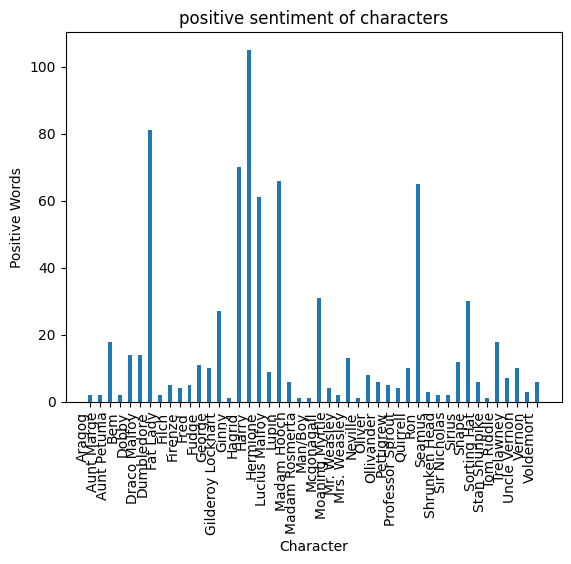

In [28]:

plt.bar(grouped_with_pos_neg["Character"], grouped_with_pos_neg["positive_words"], width = 0.4)

plt.xticks(rotation=90, ha='right')

# Label the chart
plt.xlabel('Character')
plt.ylabel('Positive Words')
plt.title('positive sentiment of characters')

# Show the chart
plt.show()

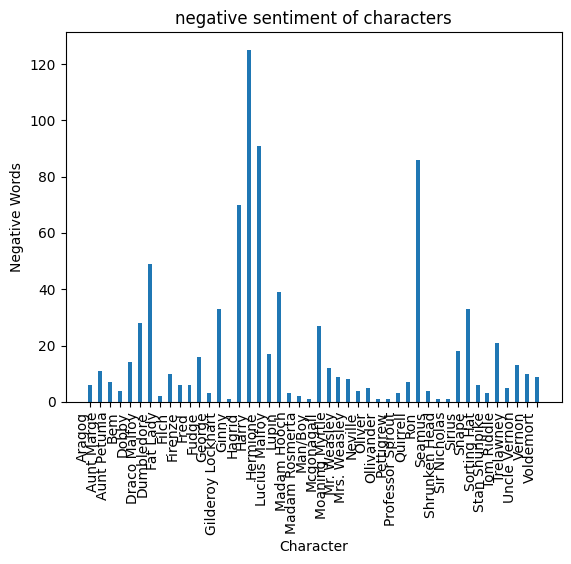

In [29]:

plt.bar(grouped_with_pos_neg["Character"], grouped_with_pos_neg["negative_words"], width = 0.4)

plt.xticks(rotation=90, ha='right')

# Label the chart
plt.xlabel('Character')
plt.ylabel('Negative Words')
plt.title('negative sentiment of characters')

# Show the chart
plt.show()

In [63]:
def pos_neg_diff(pos, neg):
    if pos > neg:
        return "Positive"
    if neg > pos:
        return "Negative"
    else:
        return "Neutral"
grouped_with_pos_neg["Positive/Negative"] = grouped_with_pos_neg.apply(
    lambda row: pos_neg_diff(row["positive_words"], row["negative_words"]), axis=1)

grouped_with_pos_neg
selected_columns = grouped_with_pos_neg[['Character', 'Positive/Negative']]
selected_rows_pos = selected_columns[selected_columns['Positive/Negative'] == "Positive"]
selected_rows_neg = selected_columns[selected_columns['Positive/Negative'] == "Negative"]
selected_rows_neutral = selected_columns[selected_columns['Positive/Negative'] == "Neutral"]
print(selected_rows_pos)
print(selected_rows_neg)
print(selected_rows_neutral)

           Character Positive/Negative
3       Aunt Petunia          Positive
17        Dumbledore          Positive
28            George          Positive
47             Lupin          Positive
48       Madam Hooch          Positive
53        Mcgonagall          Positive
57      Mrs. Weasley          Positive
60            Oliver          Positive
61        Ollivander          Positive
66         Pettigrew          Positive
69  Professor Sprout          Positive
70          Quirrell          Positive
74     Shrunken Head          Positive
77      Sir Nicholas          Positive
91         Trelawney          Positive
            Character Positive/Negative
1              Aragog          Negative
2          Aunt Marge          Negative
6                 Bem          Negative
15       Draco Malfoy          Negative
19              Filch          Negative
20            Firenze          Negative
23               Fred          Negative
27              Fudge          Negative
29  Gilderoy Loc

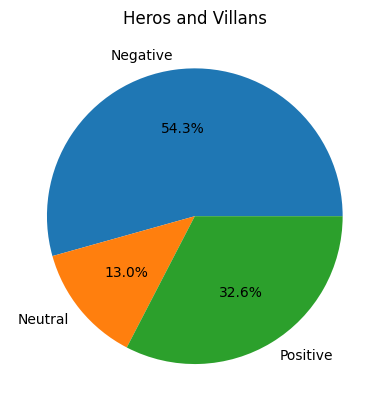

In [34]:
unique_classes, class_counts = np.unique(grouped_with_pos_neg["Positive/Negative"], return_counts=True)

plt.pie(class_counts, labels=unique_classes, autopct='%1.1f%%')
plt.title('Heros and Villans')
plt.show()

In [35]:
combined_sent_df = m.movies_df.groupby("Character").sum().reset_index()

In [36]:
def preprocessingForLDA(corp):
    # Get the list of English stop words
    custom_stop_words = ["go","get","The","And", "See", "No", "Back","Give", "would", "catch", "See", "look", "go", "well"]
    stop_words = set(stopwords.words('english')).union(custom_stop_words)
    
    # remove sequence of dots
    corp = re.sub(r'\.{2,}', ' ', corp)
    
    # Tokenize the sentences
    sentences = sent_tokenize(corp)
    prep_sentences = []
    
    # lemmatize words
    wordnet_lemmatizer = WordNetLemmatizer()

    tokens = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in words]

        #get rid of numbers and Stopwords
        words = [word for word in words if word.isalpha() and word not in stop_words]
        
        # Remove punctuation
        words = [word for word in words if word not in string.punctuation]

        # Remove pronouns
        words = [word for word in words if nltk.pos_tag([word])[0][1] != "PRP"]

        if len(words) != 0:
            tokens.extend(words)
            prep_sentences.append(words)
        
    corp = ' '.join(tokens)
    
    return tokens, corp, prep_sentences

In [37]:
'''
Latent Dirichlet Allocation- LDA modelling 

1. Pass the corpus for each character. Corpus consists of lemmatized words and keywords without numbers, punctuation, stop words
2. Creating the Dictionary
3. Convert the words in the corpus to a Bag of Words model.
4. Each Character has a model trained with of 5 topics.
'''

def ldaModelling(corp):
    num_topics = 5
    dictionary = corpora.Dictionary(corp)
    corpus = [dictionary.doc2bow(doc) for doc in corp]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=30)
    return lda_model

In [39]:
topics_df = pd.DataFrame(columns = ["Character", "t1", "t2", "t3", "t4", "t5"])
for index,row in combined_sent_df.iterrows():
    prep_words, prep_text, prep_sent = preprocessingForLDA(row["Sentence"])
    if len(prep_sent) != 0:
        ldamodel1 = ldaModelling(prep_sent)
        topics = ldamodel1.show_topics(num_topics=5, num_words=5) 
        data = {"Character" : row["Character"], "t1": topics[0][1], "t2": topics[1][1], "t3": topics[2][1], "t4": topics[3][1], "t5": topics[4][1]}
        topics_df.loc[len(topics_df)] = data

In [60]:
topics_df.head(20)
for i,r in topics_df.iterrows():
    print(r["Character"])
    print(r["t1"])
    print(r["t2"])
    print(r["t3"])
    print(r["t4"])
    print(r["t5"] + "\n\n\n")

All
0.600*"AHHHHHHH" + 0.100*"Sorcerer" + 0.100*"Stone" + 0.100*"know" + 0.100*"YAY"
0.200*"AHHHHHHH" + 0.200*"know" + 0.200*"Sorcerer" + 0.200*"Stone" + 0.200*"YAY"
0.240*"Sorcerer" + 0.240*"Stone" + 0.240*"YAY" + 0.240*"know" + 0.040*"AHHHHHHH"
0.200*"AHHHHHHH" + 0.200*"Sorcerer" + 0.200*"Stone" + 0.200*"know" + 0.200*"YAY"
0.200*"AHHHHHHH" + 0.200*"Sorcerer" + 0.200*"Stone" + 0.200*"YAY" + 0.200*"know"



Aragog
0.026*"Hagrid" + 0.026*"never" + 0.026*"open" + 0.026*"send" + 0.026*"discover"
0.026*"men" + 0.026*"land" + 0.026*"monster" + 0.026*"part" + 0.026*"meat"
0.115*"Hagrid" + 0.059*"never" + 0.022*"creature" + 0.022*"friend" + 0.022*"saw"
0.026*"Hagrid" + 0.026*"never" + 0.026*"castle" + 0.026*"open" + 0.026*"distant"
0.026*"men" + 0.026*"land" + 0.026*"monster" + 0.026*"part" + 0.026*"meat"



Aunt Marge
0.045*"bite" + 0.045*"wrong" + 0.045*"something" + 0.045*"boy" + 0.025*"nonsense"
0.090*"Come" + 0.015*"Do" + 0.015*"Vernon" + 0.015*"say" + 0.015*"orphanage"
0.127*"Vernon" +

In [33]:
def topic2list(topic):
    words = [word.strip('".+*0123456789') for word in topic.split()]
    
    # Filter out empty strings
    words = [word for word in words if word]
    return words

In [34]:
topic2list('0.041*"catch" + 0.041*"seeker" + 0.041*"ball" + 0.041*"fast" + 0.041*"damn"')

['catch', 'seeker', 'ball', 'fast', 'damn']

In [35]:
def createWordnetPlot(word_frequencies):
    wordcloud = WordCloud(width=800, height=400, background_color='white')

    # Generate the word cloud from the word frequency data
    wordcloud.generate_from_frequencies(word_frequencies)
    
    # Display the word cloud using Matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def countWords(df):
    word_list = []

    for i,row in df.iterrows():
        word_list.extend(topic2list(row["t1"]))
        word_list.extend(topic2list(row["t2"]))
        word_list.extend(topic2list(row["t3"]))
        word_list.extend(topic2list(row["t4"]))
        word_list.extend(topic2list(row["t5"]))

    # Use Counter to count the occurrences of each word
    word_count = Counter(word_list)
    
    # Convert the result to a dictionary if needed
    word_count_dict = dict(word_count)
    
    return word_count_dict


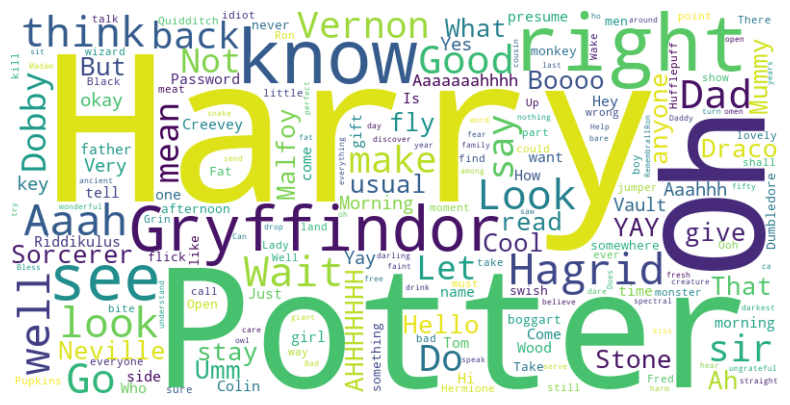

In [42]:
createWordnetPlot(countWords(topics_df))

In [60]:
'''
Task 4, 5, 6

'''


# Combine sentences for each character
combined_sentences = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()

#Add columns for Vocabulary, vocabulary size, unique words (mentioned one time) ans most frequent words
combined_sentences['vocabulary'] = None
combined_sentences['vocabulary_size'] = None
combined_sentences['words_mentioned_once'] = None
combined_sentences['most_frequent_words'] = None

In [61]:
def PreProcessToCombinedSentences(words):
    StopWords=stopwords.words('english')
    words = [word for word in words if word not in StopWords]
    
    return words


In [62]:
def generate_Vocabulary_UniqueWords_WordsFrequency(combined_sentences) :

    for index, row in combined_sentences.iterrows():
        character = row['Character']
        sentences = row['Sentence']

        # sentences = PreProcessToRemoveDelimetersAndNumbers(sentences)
        # Tokenize the text into words
        words = nltk.word_tokenize(sentences)  
        words = [word.lower() for word in words if word.isalpha()]
        
        # Create a vocabulary (set of unique words)
        vocabulary = set(words)
    
        # Convert the set back to a sorted list if needed
        vocabulary_list = sorted(list(vocabulary))
    
        combined_sentences.at[index, 'vocabulary']=vocabulary_list
    
        # Calculate vocabulary size (total unique words)
        vocabulary_size = len(set(vocabulary))
    
        # row['vocabulary_size']==vocabulary_size
        combined_sentences.at[index, 'vocabulary_size'] = vocabulary_size
        
        words = PreProcessToCombinedSentences(words)
    
        # Create a word frequency dictionary
        word_frequency = Counter(words)
    
        # Find words mentioned only once
        words_mentioned_once = [word for word, freq in word_frequency.items() if freq == 1]
        combined_sentences.at[index, 'words_mentioned_once']=words_mentioned_once
    
        # Find the thirty most frequent words
        most_frequent_words_list = word_frequency.most_common(30)
        # Extract the words from the list of tuples
        most_frequent_words = [word for word, count in most_frequent_words_list]
        combined_sentences.at[index, 'most_frequent_words']=most_frequent_words


In [63]:
generate_Vocabulary_UniqueWords_WordsFrequency(combined_sentences)

In [64]:
#Display the result
print(combined_sentences['vocabulary'])

0     [about, ahhhhhhh, know, sorcerer, stone, the, ...
1     [a, above, accused, all, an, ancient, and, any...
2     [a, about, actually, all, an, and, are, at, ba...
3     [a, abnormal, all, and, anything, are, arrive,...
4                                                [aaah]
                            ...                        
94    [all, are, blood, boy, come, deaf, die, harry,...
95    [a, again, all, and, another, arrrhhhhhh, ask,...
96                                      [harry, potter]
97    [are, at, back, believe, ca, come, crockford, ...
98    [a, all, and, believe, booked, ca, cancel, cha...
Name: vocabulary, Length: 99, dtype: object


In [65]:
print(combined_sentences['vocabulary_size'])

0       8
1      83
2     118
3     155
4       1
     ... 
94     32
95     97
96      2
97     30
98     71
Name: vocabulary_size, Length: 99, dtype: object


In [66]:
print(combined_sentences['words_mentioned_once'])

0                [ahhhhhhh, yay, know, sorcerer, stone]
1     [yes, sent, men, hollow, lie, opened, chamber,...
2     [still, ungrateful, way, damn, brother, keep, ...
3     [comes, birthday, cook, breakfast, try, burn, ...
4                                                [aaah]
                            ...                        
94    [smell, rip, want, must, die, watch, boy, tryi...
95    [use, boy, let, speak, strength, potter, meet,...
96                                      [harry, potter]
97    [doris, crockford, mr, potter, ca, believe, me...
98    [spent, summer, devising, whole, program, gon,...
Name: words_mentioned_once, Length: 99, dtype: object


In [67]:
print(combined_sentences['most_frequent_words'])

0                [ahhhhhhh, yay, know, sorcerer, stone]
1     [hagrid, never, castle, yes, sent, men, hollow...
2     [boy, vernon, little, petunia, something, say,...
3     [get, go, day, going, oh, lovely, vernon, got,...
4                                                [aaah]
                            ...                        
94    [kill, blood, time, come, let, put, light, sme...
95    [harry, see, something, lies, enough, live, gi...
96                                      [harry, potter]
97    [doris, crockford, mr, potter, ca, believe, me...
98    [new, quidditch, train, today, professor, seek...
Name: most_frequent_words, Length: 99, dtype: object


In [68]:
combined_sentences.sort_values('vocabulary_size', ascending=False).head(50)

Character                                           Sentence  \
37              Harry  Yes, Aunt Petunia. Yes, Uncle Vernon. He's asl...   
40           Hermione  Has anyone seen a toad? A boy named Neville's ...   
71                Ron  Excuse me. Do you mind? Everywhere else is ful...   
17         Dumbledore  I should've known that you would be here, Prof...   
36             Hagrid  Professor Dumbledore, sir. Professor McGonagal...   
47              Lupin  Here, eat this. It'll help. It's all right. It...   
53         Mcgonagall  Good evening, Professor Dumbledore. Are the ru...   
81              Snape  There will be no foolish wand-waving or silly ...   
29  Gilderoy Lockhart  Let me introduce you to your new Defense Again...   
15       Draco Malfoy  It's true then, what they're saying on the tra...   
88         Tom Riddle  Professor Dumbledore. Yes, professor. I suppos...   
46      Lucius Malfoy  I'm not buying today, Mr. Borgin. But selling....   
78             Sirius  No. Only one will die tonight. Are you going t...   
27              Fudge  Bad business, Hagrid, very bad business. Had t...   
57       Mrs. Weasley  It's the same every year, packed with Muggles,...   
14              Dobby  Ha- ha- ha! Ha, ha! Ho, ho, ho! Ha, ha!  Harry...   
91       Uncle Vernon  I’m warning you, if you can’t control that blo...   
90          Trelawney  Welcome, my children. In this room, you shall ...   
19              Filch  Anyone here, my sweet? Come on. Who's there?! ...   
3        Aunt Petunia  Up. Get up! Now! Here he comes, the birthday b...   
56        Mr. Weasley  Morning, Weasleys. What a night. Nine raids. N...   
65              Percy  Oh, thats Professor Snape, head of Slytherin h...   
93             Vernon  Happy birthday, son. Hurry up! Bring my coffee...   
70           Quirrell  Harry Potter. Can't tell you how pleased I am ...   
54     Moaning Myrtle  I'm Moaning Myrtle. I wouldn't expect you to k...   
23               Fred  Honestly, woman, you call yourself our mother?...   
48        Madam Hooch  Good afternoon, class. Good afternoon, Amanda....   
2          Aunt Marge  You still here, are you? Don't say 'yes' in th...   
28             George  He's not Fred, I am. Our job is to make sure t...   
69   Professor Sprout  Morning, everyone. Good morning, Professor Spr...   
60             Oliver  Quidditch is easy enough to understand.  Each ...   
58            Neville  Trevor! Sorry. That picture's moving. The only...   
73             Seamus  I'm half and half. My dad's a Muggle. Mum's a ...   
84      Stan Shunpike  Welcome to the Knight Bus...emergency transpor...   
95          Voldemort  Use the boy He lies. Let me speak to him. I ha...   
61         Ollivander  I wondered when I'd be seeing you, Mr. Potter....   
1              Aragog  Who is it? Hagrid? Is that you? Yes. Hagrid ha...   
83        Sorting Hat  Ah, right then... hmm... right. Okay. Gryffind...   
98               Wood  I spent the summer devising a whole new Quiddi...   
20            Firenze  Harry Potter, you must leave.  You are known t...   
66          Pettigrew  Remus? Sirius. My old friends! Harry! Look at ...   
44         Lee Jordan  Hello, and welcome to Hogwarts' first Quidditc...   
16             Dudley  Wake up, cousin! We're going to the zoo! How m...   
74      Shrunken Head  Yeah, take it away, Ernie. It's going to be a ...   
45           Lockhart  It can't be. Harry Potter? Nice big smile, Har...   
50     Madam Rosmerta  It'd be a lot better if the Ministry wasn't se...   
49      Madam Pomfrey  Mr. Malfoy, stop making such a fuss. You can g...   
52            Man/Boy  Welcome back, Mr. Potter. Welcome back. It's a...   
22           Flitwick  One of a wizard's most rudimentary skills is l...   
55         Mr. Borgin  Mr. Malfoy! What a pleasure to see you again. ...   

                                           vocabulary vocabulary_size  \
37  [a, about, accepted, accidentally, according, ...         

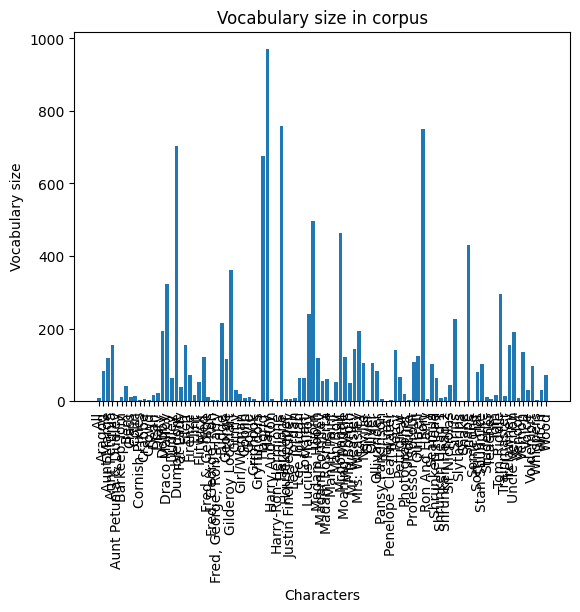

<Figure size 3000x2300 with 0 Axes>

In [69]:
# create histograms for vocabulary size of characters
def plotVocabularySizeOfCharacters(df):
    # pd.Series(df['vocabulary_size']).plot(kind='bar')
    plt.bar(df['Character'].tolist(), df['vocabulary_size'].tolist())
    plt.title("Vocabulary size in corpus")
    plt.ylabel("Vocabulary size")
    plt.xlabel("Characters")
    plt.xticks(rotation='vertical')
    plt.figure(figsize=(30, 23))
    plt.show()

plotVocabularySizeOfCharacters(combined_sentences)


In [70]:
combined_sentences_50_most_vocabulary=combined_sentences.sort_values('vocabulary_size', ascending=False).reset_index().head(50)

In [71]:
combined_sentences_50_most_vocabulary

index          Character  \
0      37              Harry   
1      40           Hermione   
2      71                Ron   
3      17         Dumbledore   
4      36             Hagrid   
5      47              Lupin   
6      53         Mcgonagall   
7      81              Snape   
8      29  Gilderoy Lockhart   
9      15       Draco Malfoy   
10     88         Tom Riddle   
11     46      Lucius Malfoy   
12     78             Sirius   
13     27              Fudge   
14     57       Mrs. Weasley   
15     14              Dobby   
16     91       Uncle Vernon   
17     90          Trelawney   
18     19              Filch   
19      3       Aunt Petunia   
20     56        Mr. Weasley   
21     65              Percy   
22     93             Vernon   
23     70           Quirrell   
24     54     Moaning Myrtle   
25     23               Fred   
26     48        Madam Hooch   
27      2         Aunt Marge   
28     28             George   
29     69   Professor Sprout   
30     60             Oliver   
31     58            Neville   
32     73             Seamus   
33     84      Stan Shunpike   
34     95          Voldemort   
35     61         Ollivander   
36      1             Aragog   
37     83        Sorting Hat   
38     98               Wood   
39     20            Firenze   
40     66          Pettigrew   
41     44         Lee Jordan   
42     16             Dudley   
43     74      Shrunken Head   
44     45           Lockhart   
45     50     Madam Rosmerta   
46     49      Madam Pomfrey   
47     52            Man/Boy   
48     22           Flitwick   
49     55         Mr. Borgin   

                                             Sentence  \
0   Yes, Aunt Petunia. Yes, Uncle Vernon. He's asl...   
1   Has anyone seen a toad? A boy named Neville's ...   
2   Excuse me. Do you mind? Everywhere else is ful...   
3   I should've known that you would be here, Prof...   
4   Professor Dumbledore, sir. Professor McGonagal...   
5   Here, eat this. It'll help. It's all right. It...   
6   Good evening, Professor Dumbledore. Are the ru...   
7   There will be no foolish wand-waving or silly ...   
8   Let me introduce you to your new Defense Again...   
9   It's true then, what they're saying on the tra...   
10  Professor Dumbledore. Yes, professor. I suppos...   
11  I'm not buying today, Mr. Borgin. But selling....   
12  No. Only one will die tonight. Are you going t...   
13  Bad business, Hagrid, very bad business. Had t...   
14  It's the same every year, packed with Muggles,...   
15  Ha- ha- ha! Ha, ha! Ho, ho, ho! Ha, ha!  Harry...   
16  I’m warning you, if you can’t control that blo...   
17  Welcome, my children. In this room, you shall ...   
18  Anyone here, my sweet? Come on. Who's there?! ...   
19  Up. Get up! Now! Here he comes, the birthday b...   
20  Morning, Weasleys. What a night. Nine raids. N...   
21  Oh, thats Professor Snape, head of Slytherin h...   
22  Happy birthday, son. Hurry up! Bring my coffee...   
23  Harry Potter. Can't tell you how pleased I am ...   
24  I'm Moaning Myrtle. I wouldn't expect you to k...   
25  Honestly, woman, you call yourself our mother?...   
26  Good afternoon, class. Good afternoon, Amanda....   
27  You still here, are you? Don't say 'yes' in th...   
28  He's not Fred, I am. Our job is to make sure t...   
29  Morning, everyone. Good morning, Professor Spr...   
30  Quidditch is easy enough to understand.  Each ...   
31  Trevor! Sorry. That picture's moving. The only...   
32  I'm half and half. My dad's a Muggle. Mum's a ...   
33  Welcome to the Knight Bus...emergency transpor...   
34  Use the boy He lies. Let me speak to him. I ha...   
35  I wondered when I'd be seeing you, Mr. Potter....   
36  Who is it? Hagrid? Is that you? Yes. Hagrid ha...   
37  Ah, right then... hmm... right. Okay. Gryffind...   
38  I spent the summer devising a whole new Quiddi...   
39  Harry Potter, you must leave.  You are known t...   
40  Remus? Sirius. My old friends!

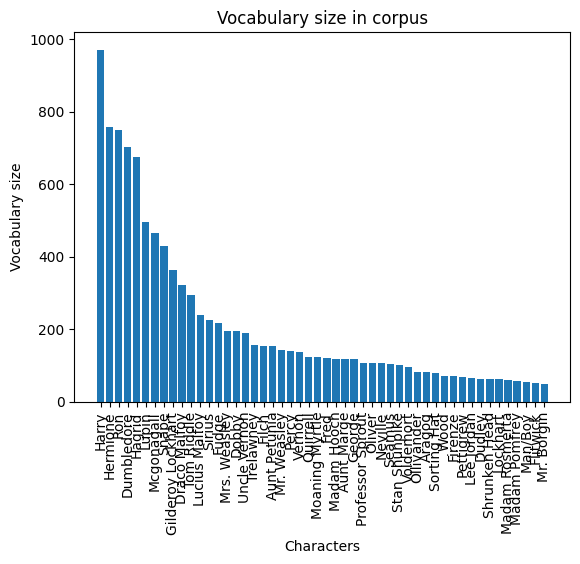

<Figure size 3000x2300 with 0 Axes>

In [72]:
plotVocabularySizeOfCharacters(combined_sentences_50_most_vocabulary)

In [73]:
combined_sentences_50_most_vocabulary['most_frequent_words']

0     [ron, hagrid, come, know, go, get, think, herm...
1     [harry, ron, go, come, one, ca, got, going, pr...
2     [harry, go, think, got, know, hermione, one, r...
3     [harry, professor, well, would, hagrid, points...
4     [harry, well, come, go, right, dumbledore, pro...
5     [harry, well, good, yes, much, see, come, memo...
6     [potter, weasley, slytherin, school, professor...
7     [potter, one, werewolf, would, well, turn, tim...
8     [harry, well, professor, let, know, see, round...
9     [potter, father, think, see, one, time, come, ...
10    [hagrid, would, ginny, dumbledore, wo, knew, v...
11    [well, potter, course, ministry, come, draco, ...
12    [remus, know, come, run, kill, rat, james, har...
13    [hagrid, come, well, business, yes, harry, oh,...
14    [dear, harry, come, oh, ron, go, first, get, s...
15    [dobby, harry, potter, sir, ho, bad, oh, ha, m...
16    [back, marge, never, go, let, come, going, oh,...
17    [shall, dear, art, cup, see, first, must, 

In [74]:
def SimilarityMatrixByCommonWords(characters, word_lists):
    text = [" ".join(word_list) for word_list in word_lists]
    # Initialize a CountVectorizer to convert text to a bag of words
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text)
    
    # Create a character-to-character Jaccard similarity matrix
    character_names = characters.tolist()
    similarity_matrix = []

    #Similarity by common words
    for i in range(len(character_names)):
        row = []
        for j in range(len(character_names)):
            if i == j:
                similarity = 1.0  # Similarity with oneself is 1.0
            else:
                set1 = set(X[i].indices)
                set2 = set(X[j].indices)
                intersection = len(set1.intersection(set2))
                union = len(set1) + len(set2) - intersection
                if union == 0:
                    similarity = 0

                else :
                    similarity = intersection / union
            row.append(similarity)
        similarity_matrix.append(row)

    #Matrix
    similarity_df = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)    

    return similarity_df

In [80]:
def CharacterToCharacterMatrixPlot(characters, matrix):
    character_names = characters.tolist()
    # Plot the character-to-character matrix
    plt.figure(figsize=(25, 25))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(character_names)), character_names, rotation='vertical')
    plt.yticks(range(len(character_names)), character_names)
    plt.title('Character-to-Character Matrix')
    plt.show()

In [81]:
def mostCommonPairs(characters, matrix, number) :
    character_names = characters.tolist()
    most_common_pairs = []
    for character1 in character_names:
        for character2 in character_names:
            if character1 != character2:
                count = matrix.at[character1, character2]
                most_common_pairs.append((character1, character2, count))
    
    # Sort the list of pairs by count in descending order
    most_common_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Display the most common pairs
    print("Most Common Pairs:")    
    for x in range(number):
        print(f"{most_common_pairs[x][0]} and {most_common_pairs[x][1]}: {most_common_pairs[x][2]} Similarity")

In [82]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Vocabulary
similarity_df = SimilarityMatrixByCommonWords(combined_sentences['Character'], combined_sentences['vocabulary'])


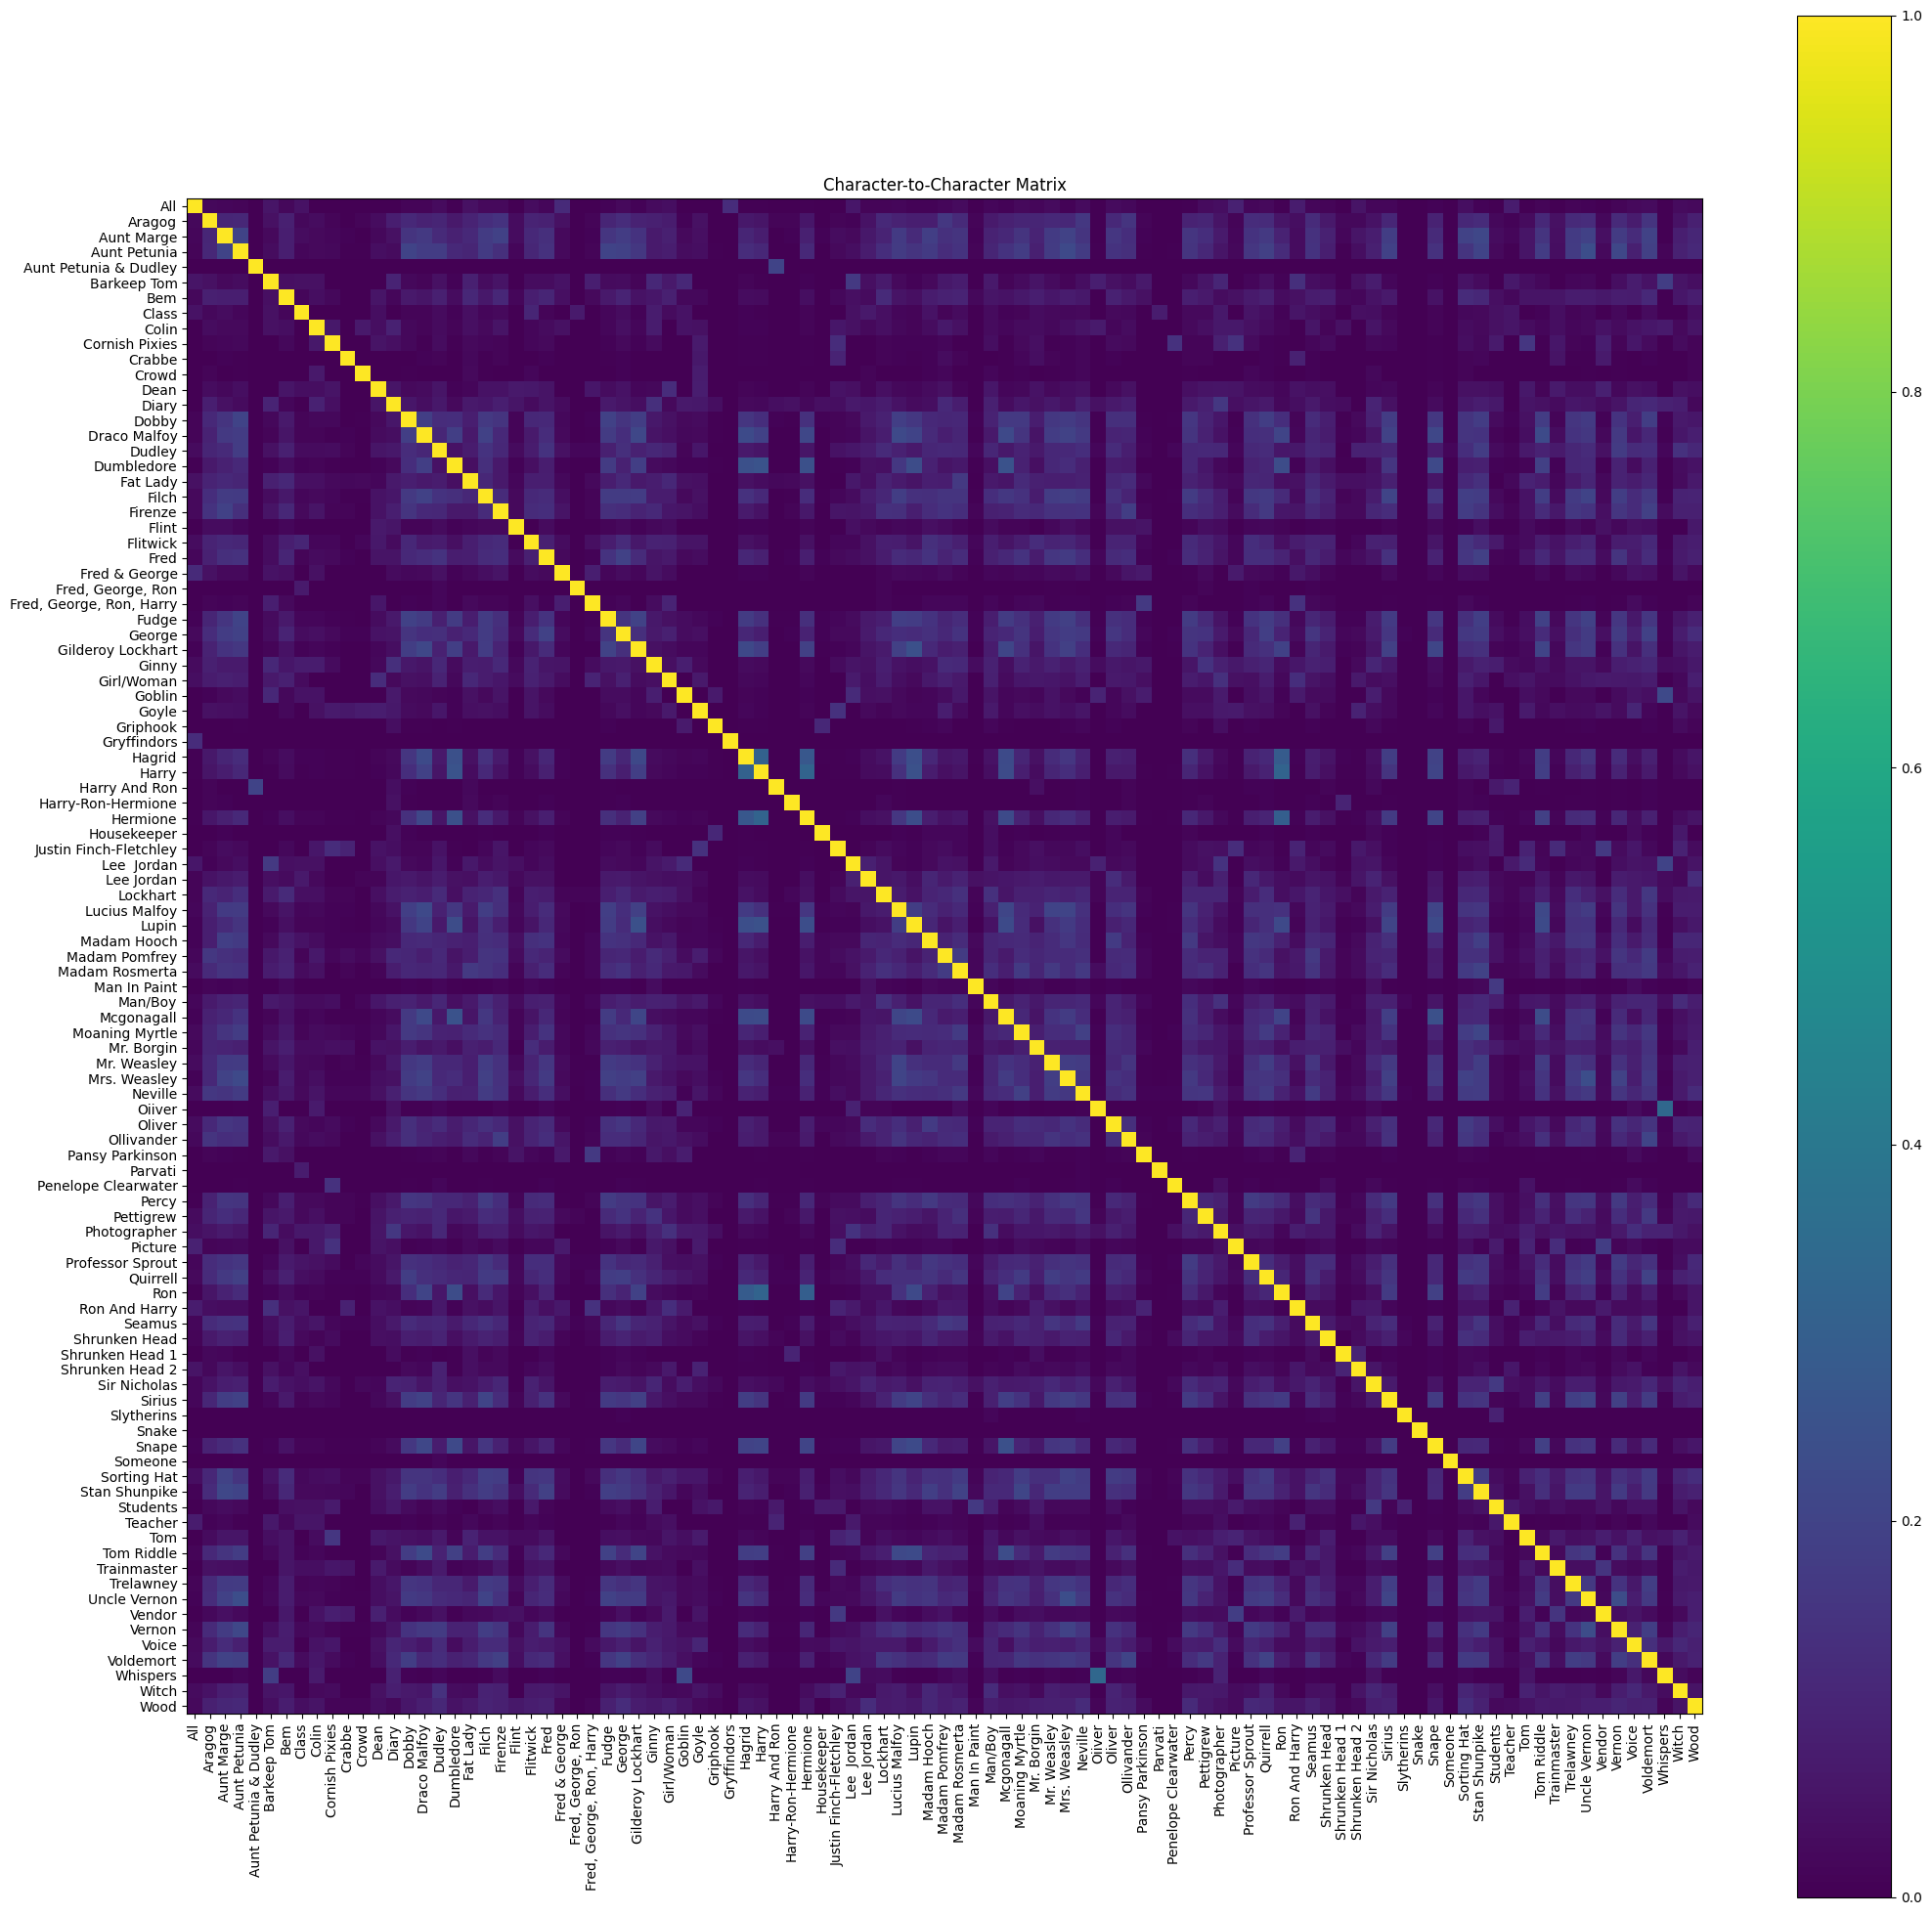

In [83]:
#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences['Character'], similarity_df)

In [84]:
#Most 30 common paris
mostCommonPairs(combined_sentences['Character'], similarity_df, 30)

Most Common Pairs:
Oiiver and Whispers: 0.3333333333333333 Similarity
Whispers and Oiiver: 0.3333333333333333 Similarity
Harry and Hermione: 0.3192632386799693 Similarity
Hermione and Harry: 0.3192632386799693 Similarity
Harry and Ron: 0.31790123456790126 Similarity
Ron and Harry: 0.31790123456790126 Similarity
Hagrid and Harry: 0.31219903691813805 Similarity
Harry and Hagrid: 0.31219903691813805 Similarity
Hermione and Ron: 0.2984429065743945 Similarity
Ron and Hermione: 0.2984429065743945 Similarity
Hagrid and Ron: 0.28701180744777477 Similarity
Ron and Hagrid: 0.28701180744777477 Similarity
Hagrid and Hermione: 0.2727272727272727 Similarity
Hermione and Hagrid: 0.2727272727272727 Similarity
Dumbledore and Harry: 0.256797583081571 Similarity
Harry and Dumbledore: 0.256797583081571 Similarity
Dumbledore and Mcgonagall: 0.2518837459634015 Similarity
Mcgonagall and Dumbledore: 0.2518837459634015 Similarity
Harry and Lupin: 0.24636441402908468 Similarity
Lupin and Harry: 0.24636441402908

In [86]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Unique words of each character
similarity_unique_words_df = SimilarityMatrixByCommonWords(combined_sentences['Character'], combined_sentences['words_mentioned_once'])

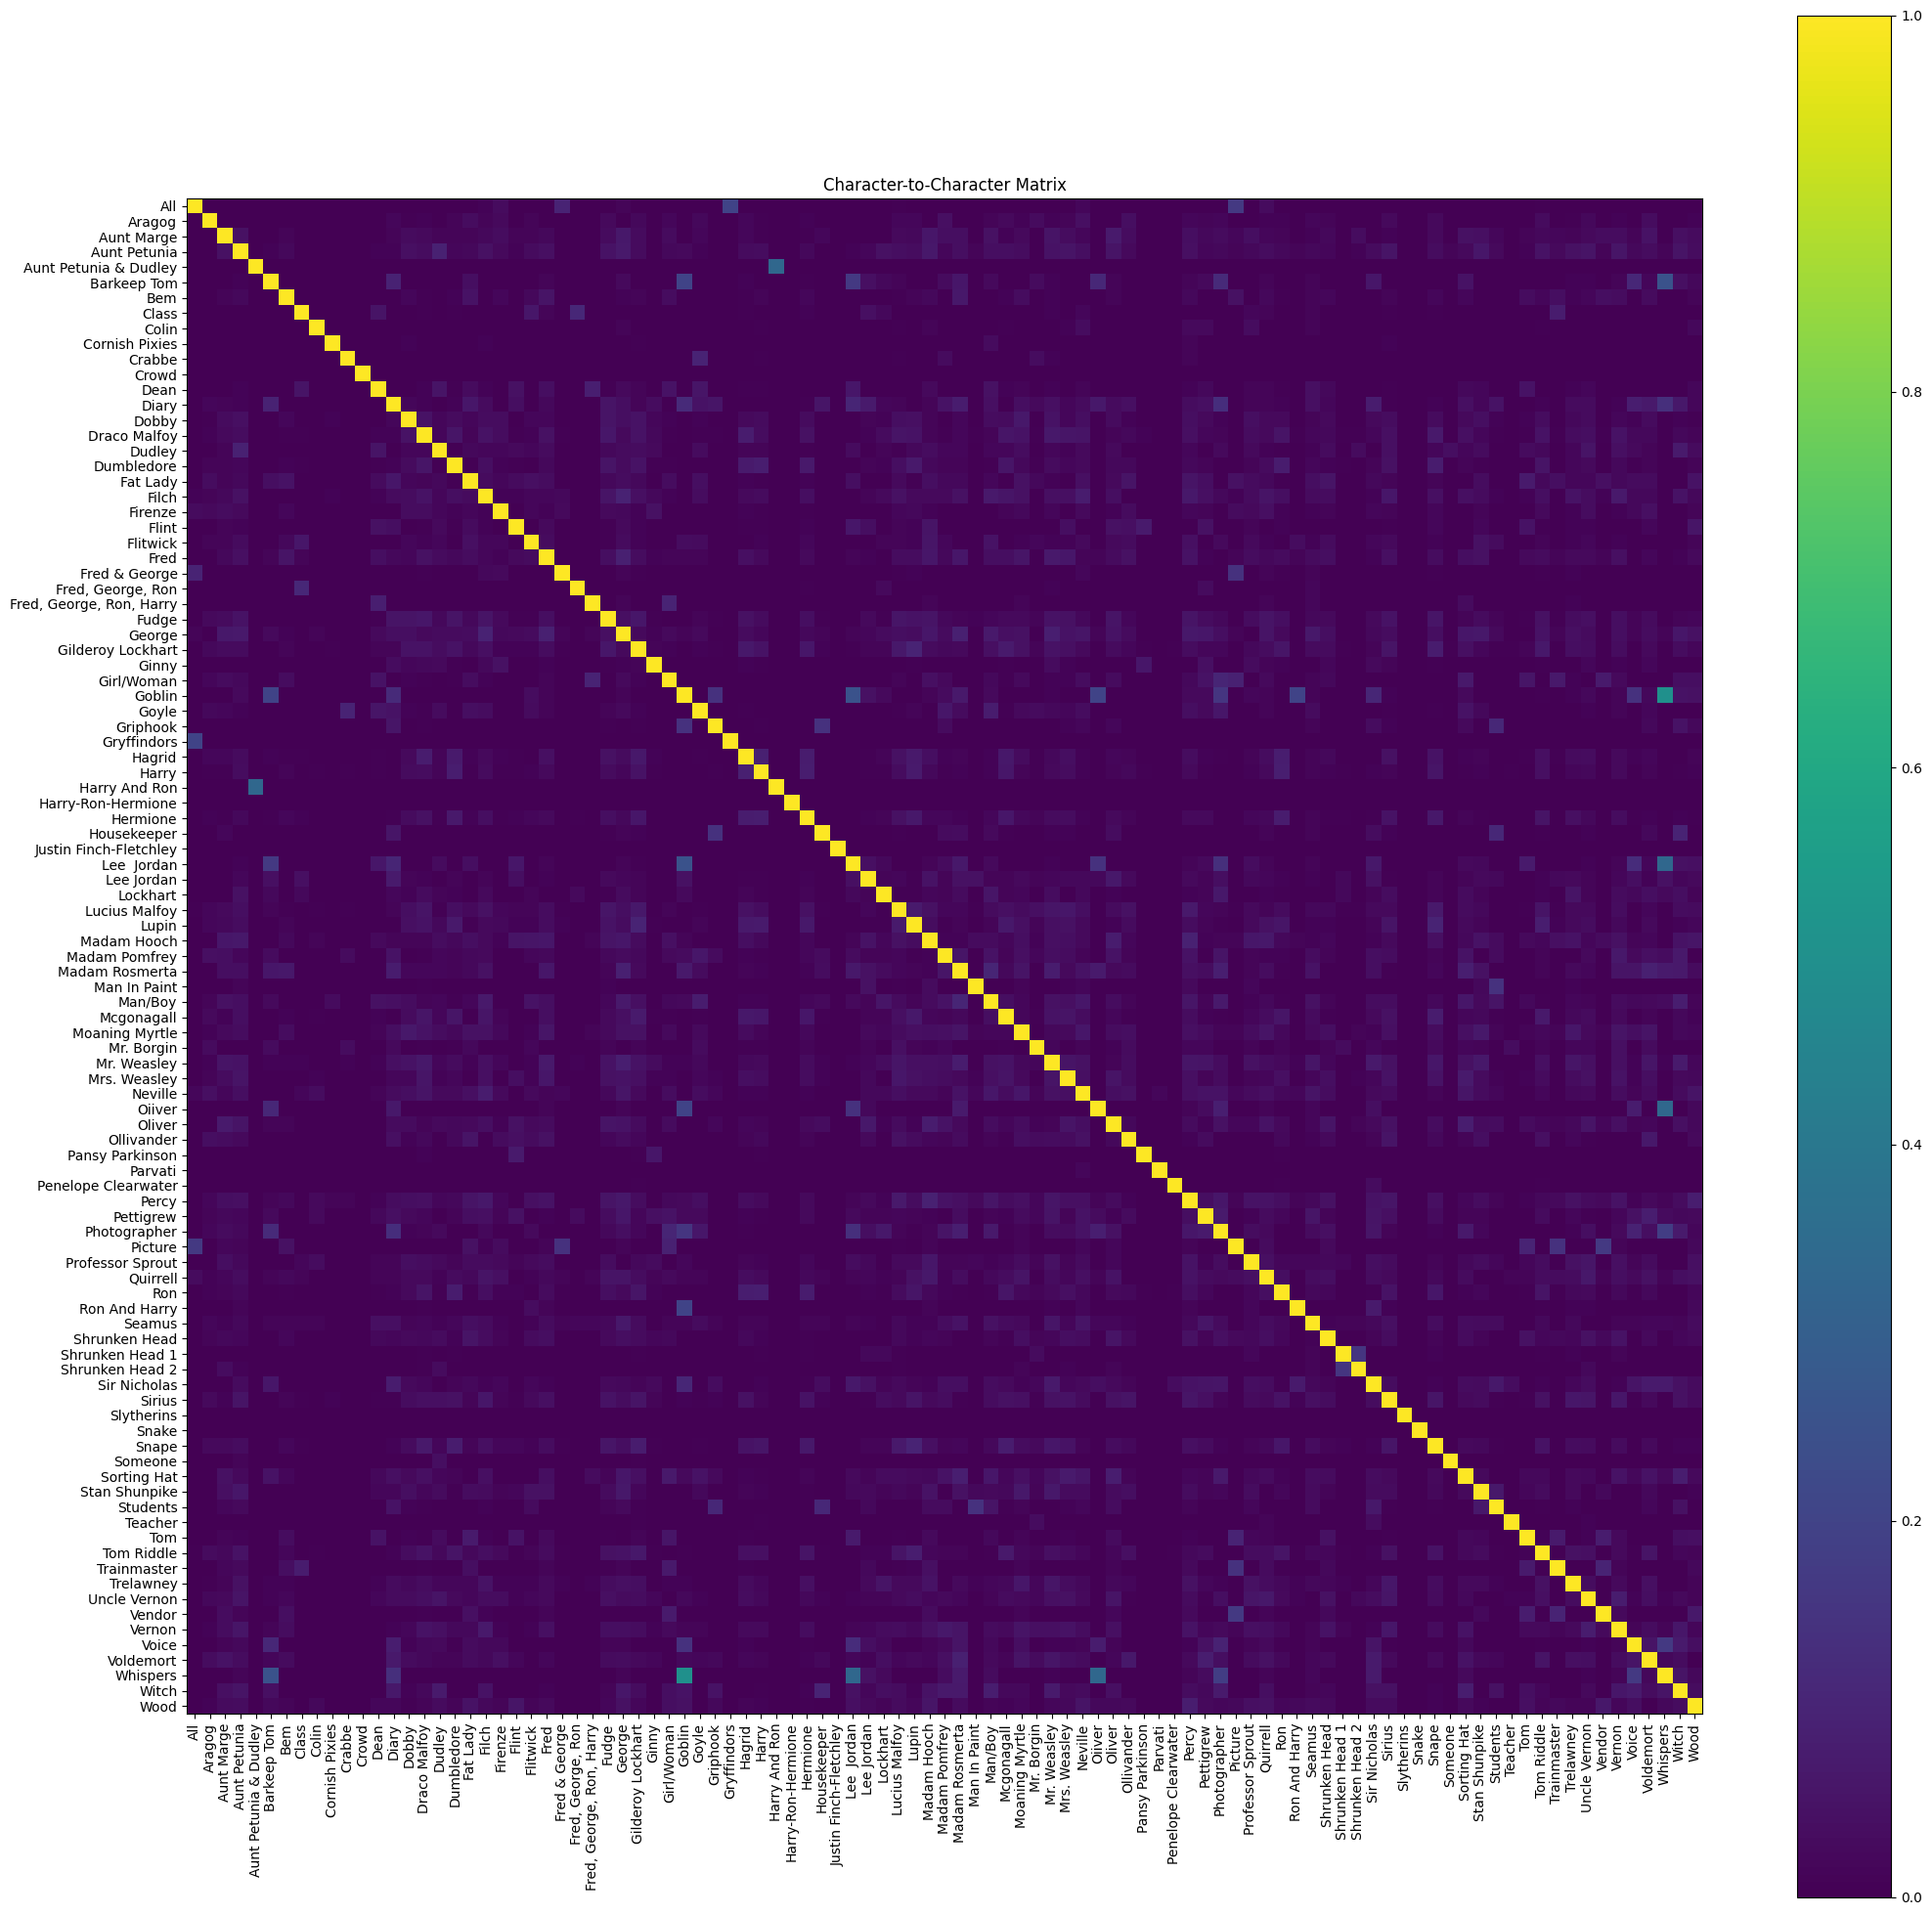

In [87]:
#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences['Character'], similarity_unique_words_df)

In [89]:
#Most common pairs
mostCommonPairs(combined_sentences['Character'], similarity_unique_words_df, 30)

Most Common Pairs:
Goblin and Whispers: 0.5 Similarity
Whispers and Goblin: 0.5 Similarity
Aunt Petunia & Dudley and Harry And Ron: 0.3333333333333333 Similarity
Harry And Ron and Aunt Petunia & Dudley: 0.3333333333333333 Similarity
Lee  Jordan and Whispers: 0.3333333333333333 Similarity
Oiiver and Whispers: 0.3333333333333333 Similarity
Whispers and Lee  Jordan: 0.3333333333333333 Similarity
Whispers and Oiiver: 0.3333333333333333 Similarity
Barkeep Tom and Whispers: 0.25 Similarity
Goblin and Lee  Jordan: 0.25 Similarity
Lee  Jordan and Goblin: 0.25 Similarity
Whispers and Barkeep Tom: 0.25 Similarity
All and Gryffindors: 0.2 Similarity
Barkeep Tom and Goblin: 0.2 Similarity
Goblin and Barkeep Tom: 0.2 Similarity
Goblin and Oiiver: 0.2 Similarity
Goblin and Ron And Harry: 0.2 Similarity
Gryffindors and All: 0.2 Similarity
Oiiver and Goblin: 0.2 Similarity
Ron And Harry and Goblin: 0.2 Similarity
Photographer and Whispers: 0.18181818181818182 Similarity
Whispers and Photographer: 0.18

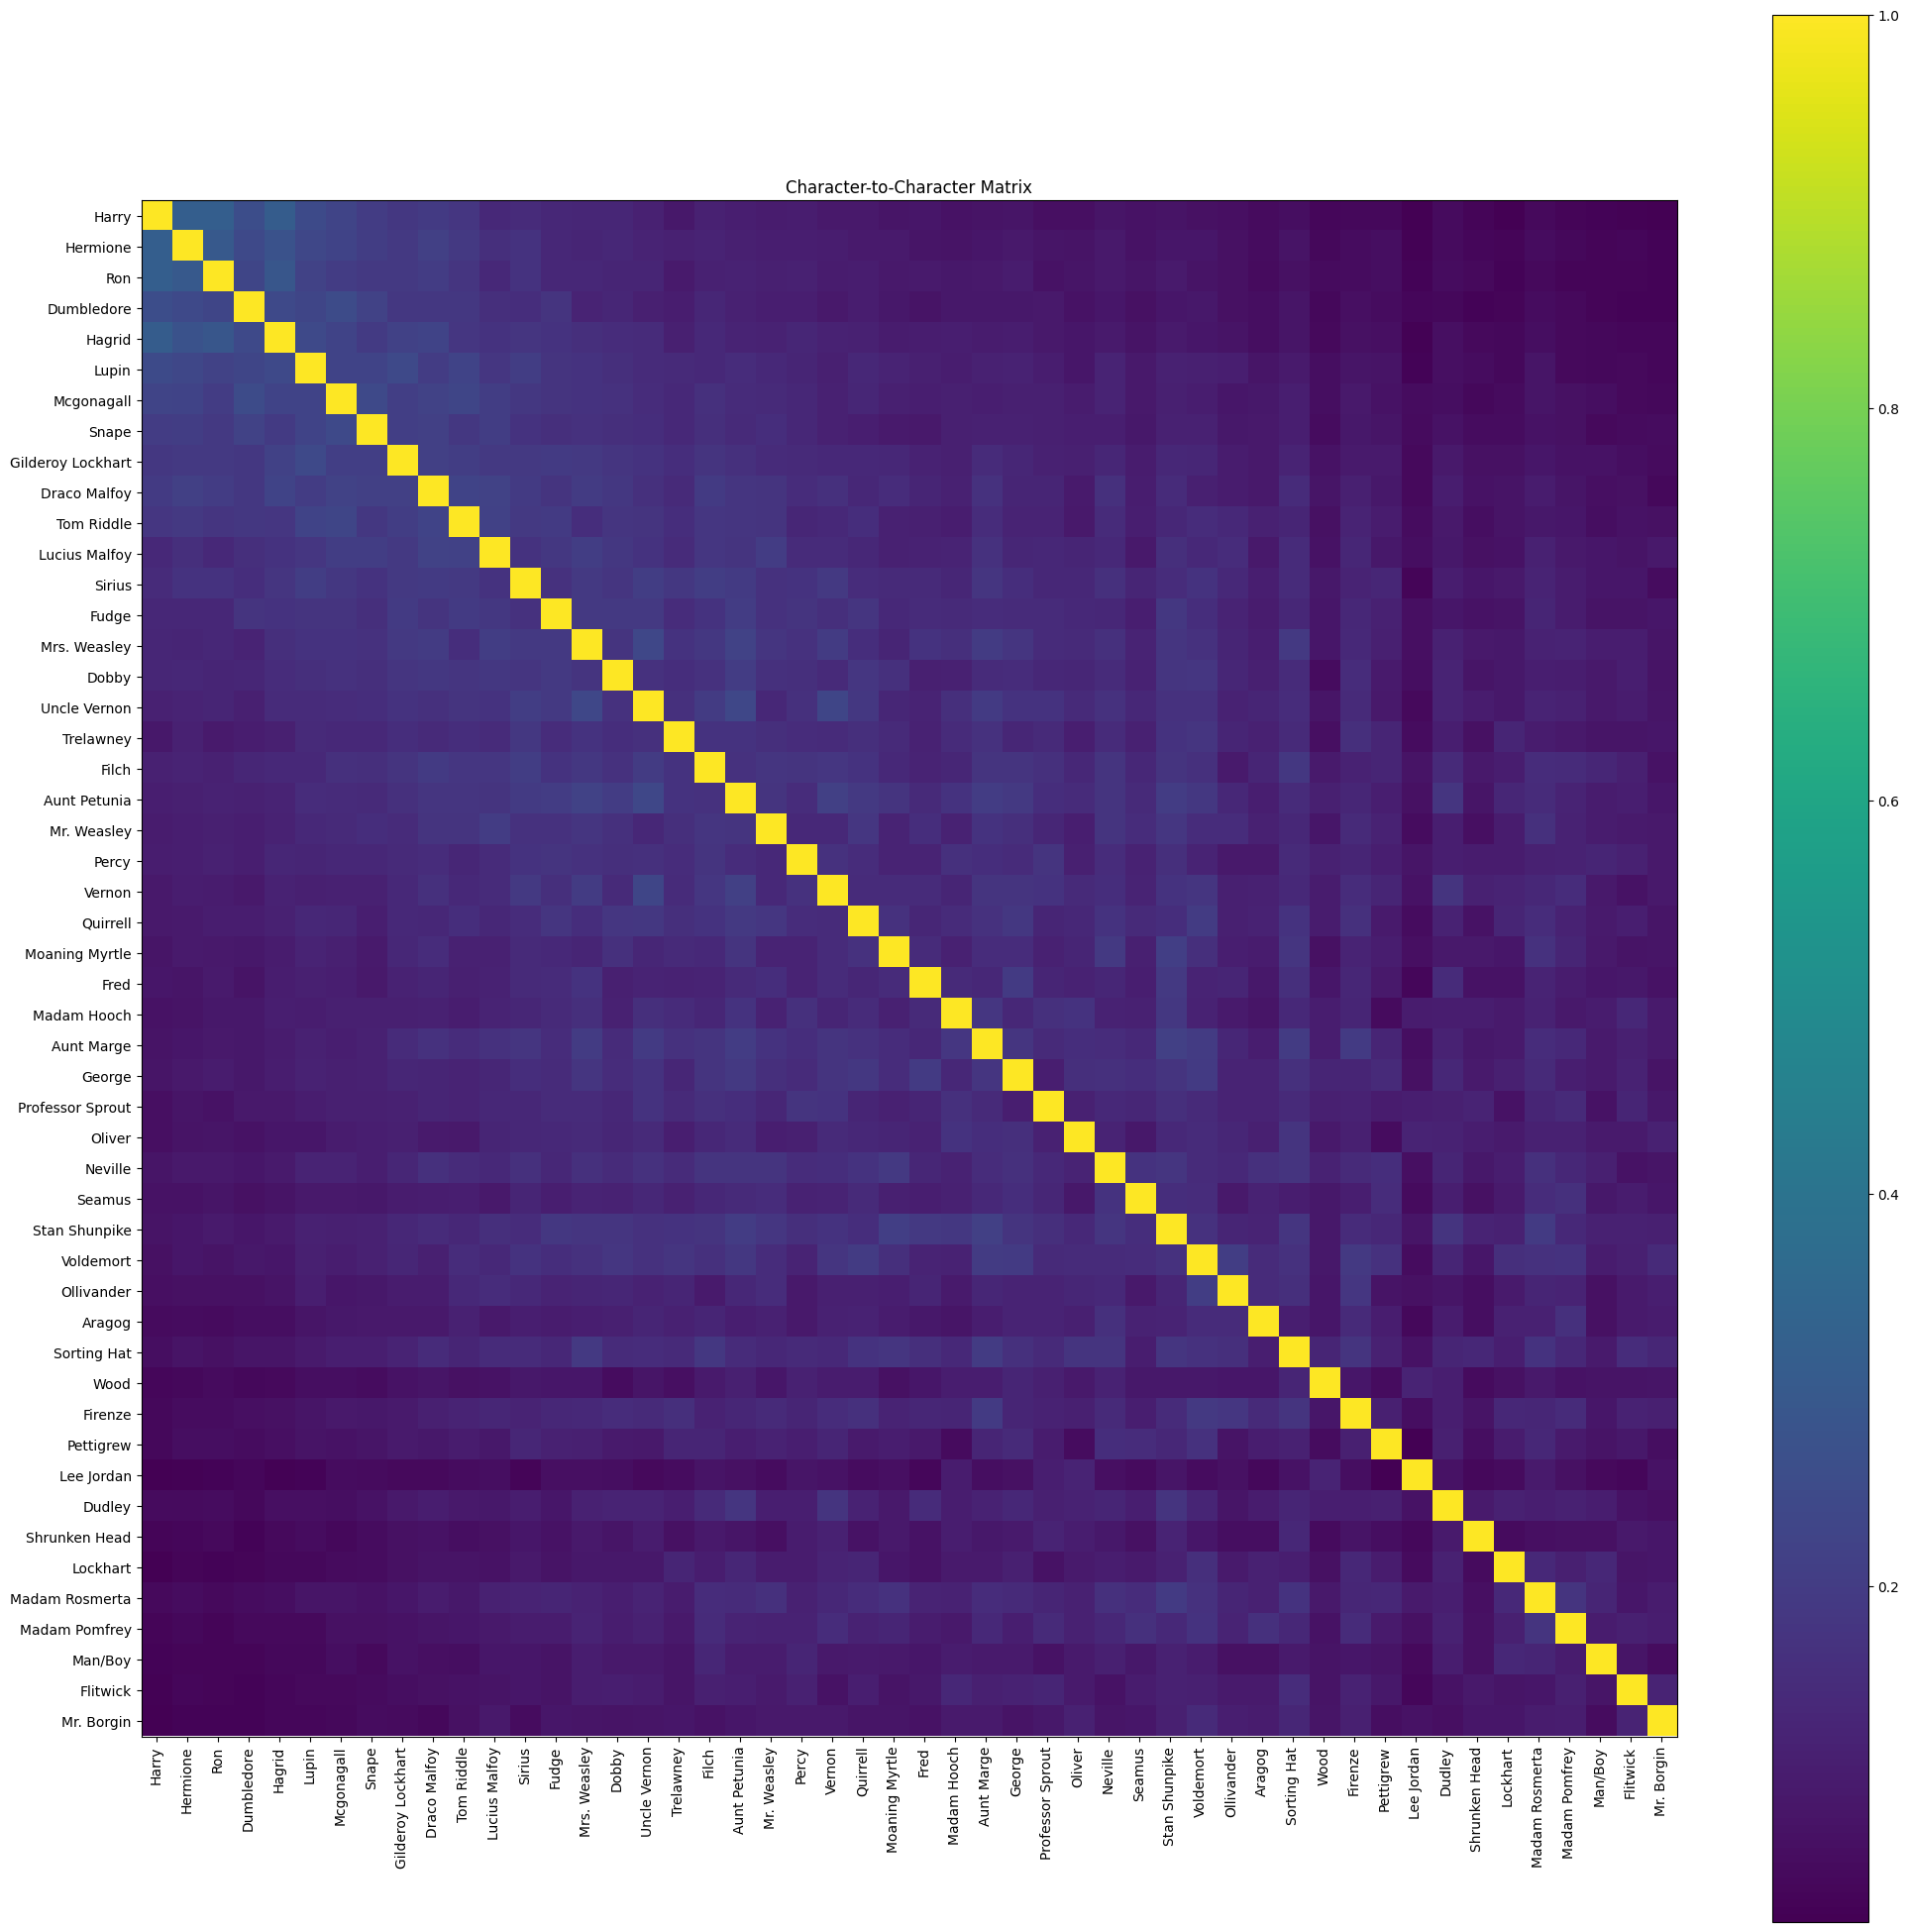

In [90]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Vocabulary
similarity_df_50_most_vocabulary = SimilarityMatrixByCommonWords(combined_sentences_50_most_vocabulary['Character'], combined_sentences_50_most_vocabulary['vocabulary'])

#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences_50_most_vocabulary['Character'], similarity_df_50_most_vocabulary)


In [91]:
#Most 30 common paris
mostCommonPairs(combined_sentences_50_most_vocabulary['Character'], similarity_df_50_most_vocabulary, 30)

Most Common Pairs:
Harry and Hermione: 0.3192632386799693 Similarity
Hermione and Harry: 0.3192632386799693 Similarity
Harry and Ron: 0.31790123456790126 Similarity
Ron and Harry: 0.31790123456790126 Similarity
Harry and Hagrid: 0.31219903691813805 Similarity
Hagrid and Harry: 0.31219903691813805 Similarity
Hermione and Ron: 0.2984429065743945 Similarity
Ron and Hermione: 0.2984429065743945 Similarity
Ron and Hagrid: 0.28701180744777477 Similarity
Hagrid and Ron: 0.28701180744777477 Similarity
Hermione and Hagrid: 0.2727272727272727 Similarity
Hagrid and Hermione: 0.2727272727272727 Similarity
Harry and Dumbledore: 0.256797583081571 Similarity
Dumbledore and Harry: 0.256797583081571 Similarity
Dumbledore and Mcgonagall: 0.2518837459634015 Similarity
Mcgonagall and Dumbledore: 0.2518837459634015 Similarity
Harry and Lupin: 0.24636441402908468 Similarity
Lupin and Harry: 0.24636441402908468 Similarity
Dumbledore and Hagrid: 0.24478694469628287 Similarity
Hagrid and Dumbledore: 0.24478694

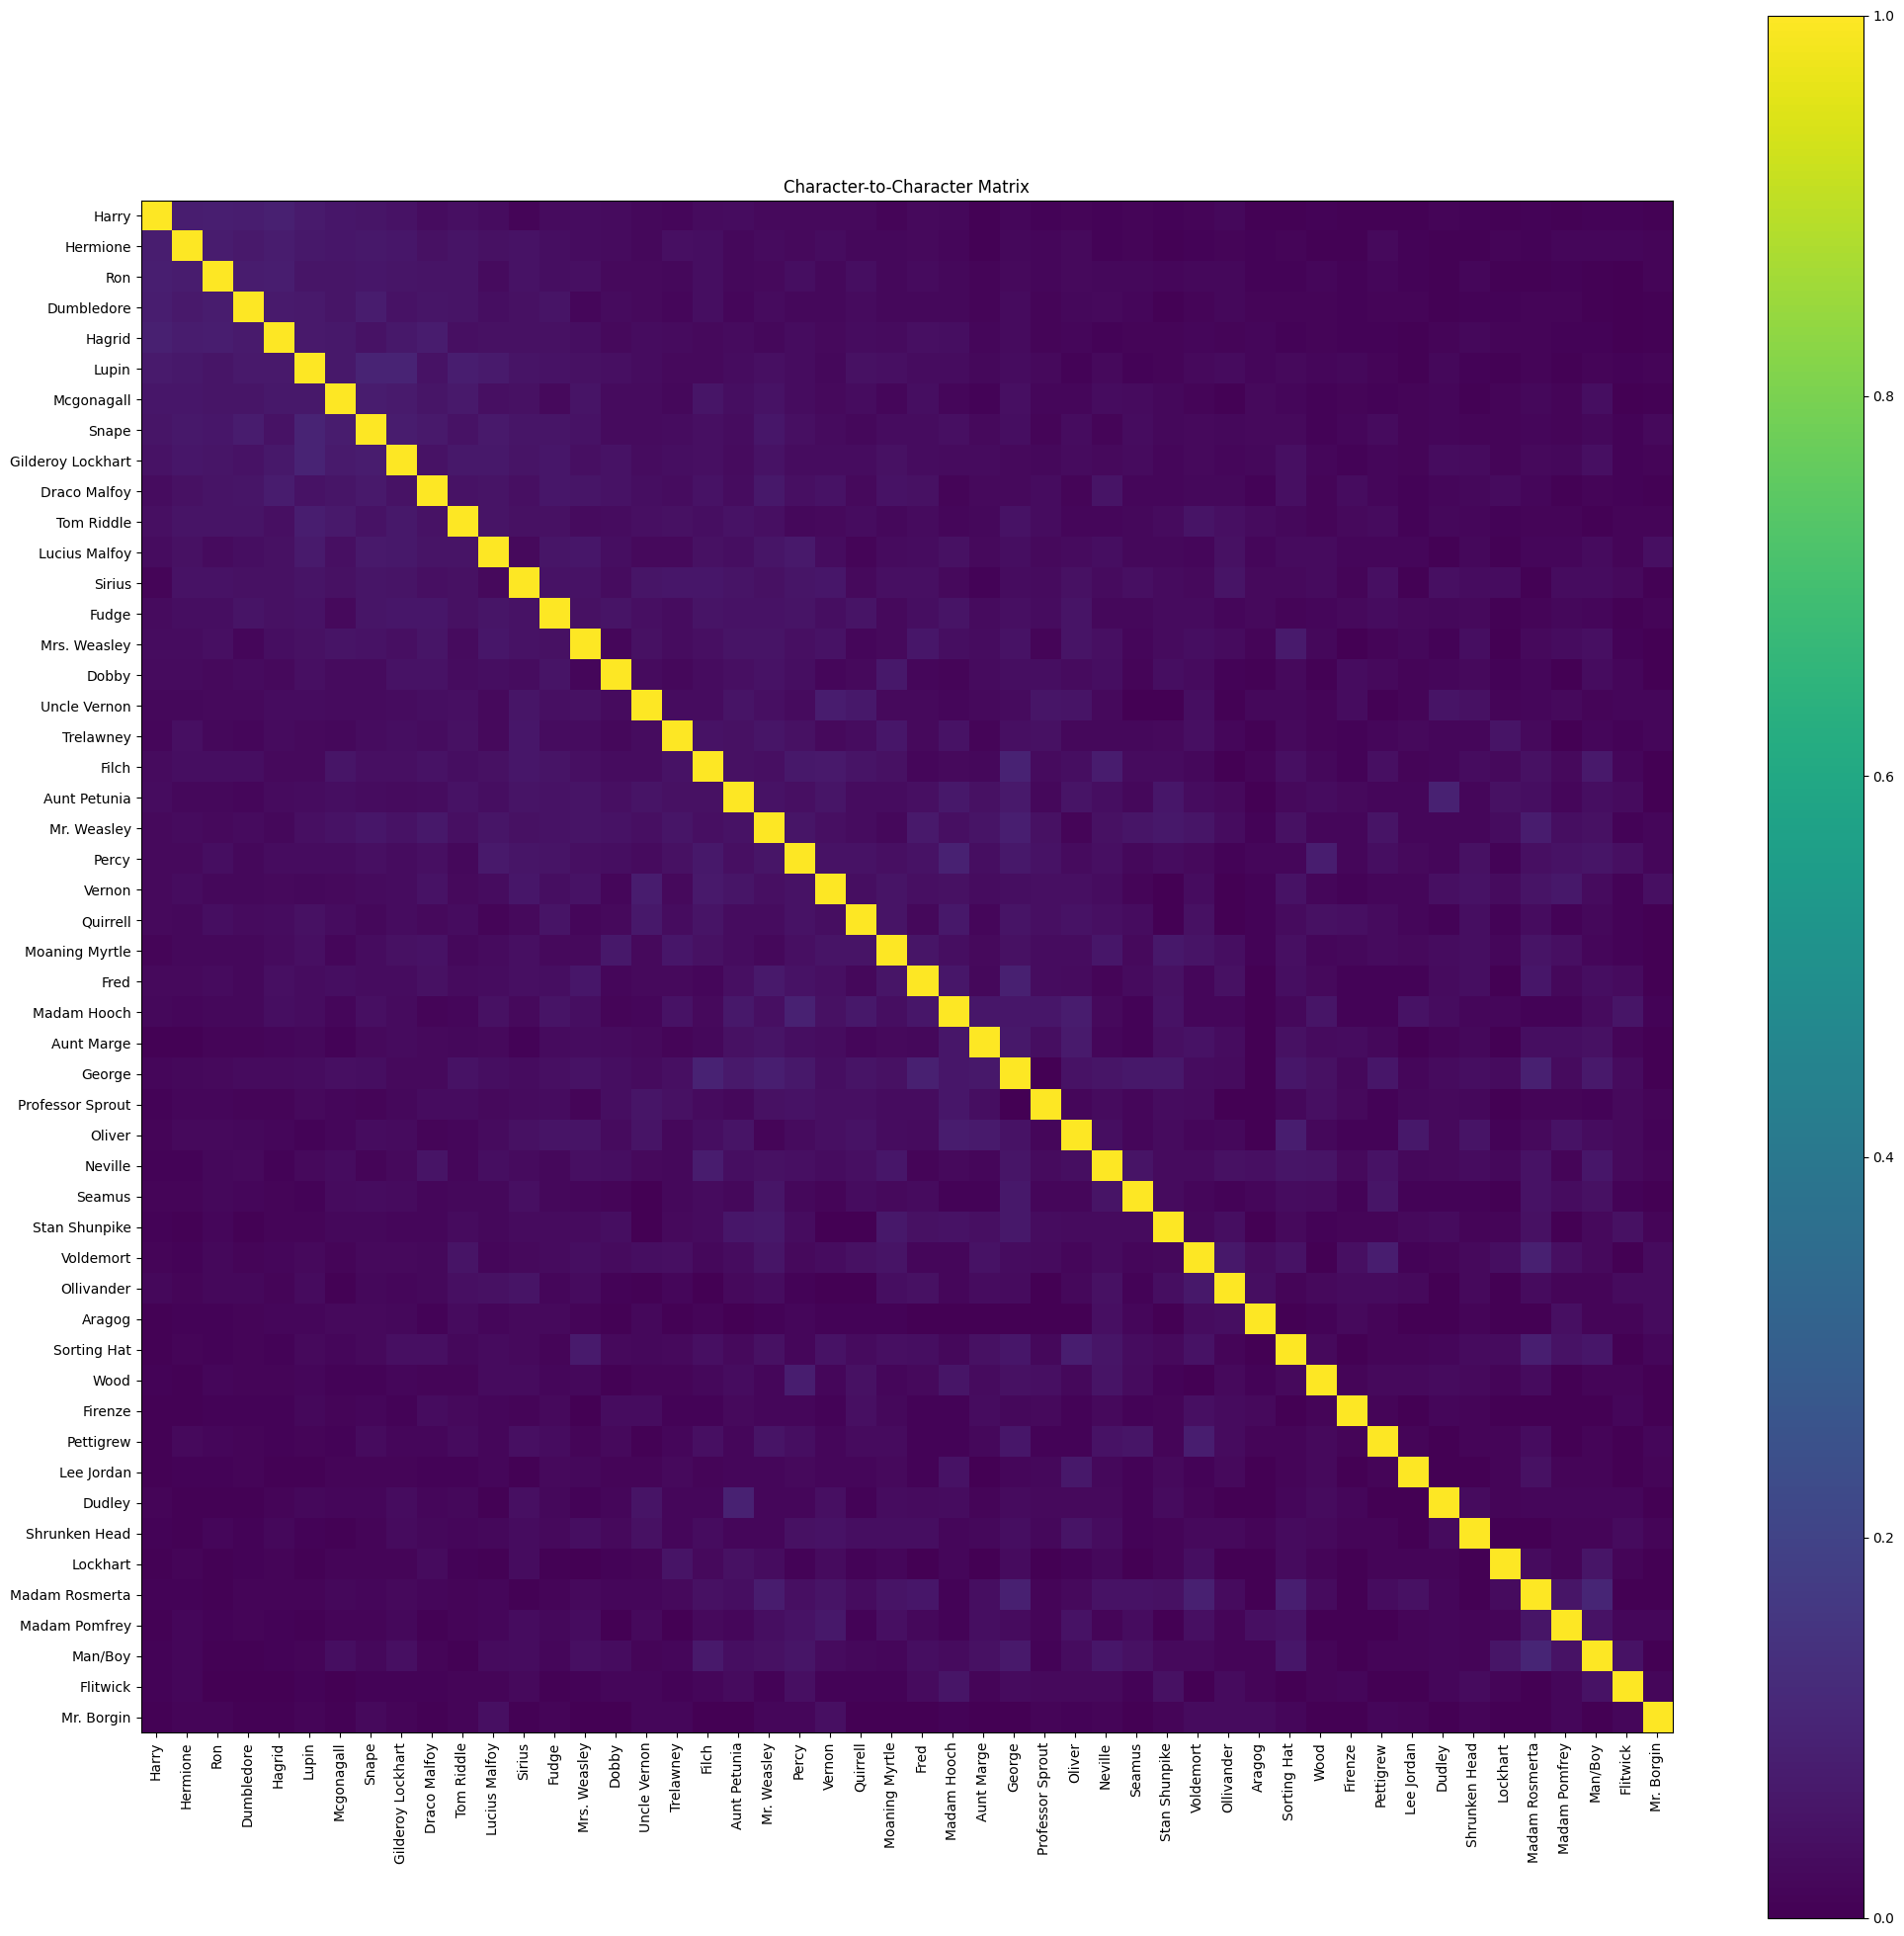

In [92]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Unique words of each character
similarity_unique_words_df_50_most_vocabulary = SimilarityMatrixByCommonWords(combined_sentences_50_most_vocabulary['Character'], combined_sentences_50_most_vocabulary['words_mentioned_once'])

#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences_50_most_vocabulary['Character'], similarity_unique_words_df_50_most_vocabulary)


In [93]:
#Plot the matrix
mostCommonPairs(combined_sentences_50_most_vocabulary['Character'], similarity_unique_words_df_50_most_vocabulary, 30)

Most Common Pairs:
Madam Rosmerta and Man/Boy: 0.10526315789473684 Similarity
Man/Boy and Madam Rosmerta: 0.10526315789473684 Similarity
Lupin and Gilderoy Lockhart: 0.10062893081761007 Similarity
Gilderoy Lockhart and Lupin: 0.10062893081761007 Similarity
Lupin and Snape: 0.09826589595375723 Similarity
Snape and Lupin: 0.09826589595375723 Similarity
Filch and George: 0.0958904109589041 Similarity
George and Filch: 0.0958904109589041 Similarity
Aunt Petunia and Dudley: 0.09090909090909091 Similarity
Dudley and Aunt Petunia: 0.09090909090909091 Similarity
Percy and Madam Hooch: 0.09022556390977443 Similarity
Madam Hooch and Percy: 0.09022556390977443 Similarity
Fred and George: 0.08888888888888889 Similarity
George and Fred: 0.08888888888888889 Similarity
Harry and Hagrid: 0.08774193548387096 Similarity
Hagrid and Harry: 0.08774193548387096 Similarity
George and Madam Rosmerta: 0.08695652173913043 Similarity
Voldemort and Madam Rosmerta: 0.08695652173913043 Similarity
Madam Rosmerta and

In [95]:
#10
# load histwords as gensim KeyedVectors
def load_historical_embeddings(year, path):
    with open(path + str(year) + "-vocab.pkl", "rb") as f:
        vocab = pickle.load(f)
    np.bool = np.bool_

    vectors = np.load(path + str(year) + "-w.npy", mmap_mode="c")
    
    kv = KeyedVectors(vector_size=vectors.shape[1])
    # kv.add_vector(key=vocab, vector=vectors) 
    kv.add_vectors(keys=vocab, weights=vectors, extras=None, replace=False)
    # kv.add(entities=vocab, weights=vectors)
   
    return kv

emb_fic = OrderedDict()
fic_path = './models/sgns/'
for year in range(1900, 2000, 10):
    emb_fic[year] = load_historical_embeddings(year, path=fic_path)

In [96]:
Character_sentences= m.movies_df
for index, row in Character_sentences.iterrows():
    character = row['Character']
    sentences = row['Sentence']

    # sentences = PreProcessToRemoveDelimetersAndNumbers(sentences)
    # Tokenize the text into words
    words = nltk.word_tokenize(sentences)  
    words = [word.lower() for word in words if word.isalpha()]
    words = PreProcessToCombinedSentences(words)
    sentence = " ".join(words)
    Character_sentences.at[index, 'Sentence']=sentence

Character_sentences

# Extract sentences from the character corpus DataFrame
character_sentences = Character_sentences['Sentence'].str.split().tolist()
character_sentences

[['lumos', 'maxima'],
 ['lumos', 'maxima'],
 ['lumos', 'maxima'],
 ['lumos', 'maxima'],
 ['harry', 'harry'],
 ['harry', 'open', 'door'],
 ['marge', 'lovely'],
 ['uncle', 'vernon', 'need', 'sign', 'form'],
 [],
 ['nothing', 'school', 'stuff'],
 ['later', 'perhaps', 'behave'],
 [],
 ['still'],
 ['yes'],
 ['say', 'ungrateful', 'way'],
 ['damn', 'good', 'brother', 'keep'],
 ['straight', 'orphanage', 'dumped', 'doorstep'],
 ['dudders'],
 ['little'],
 ['give', 'us', 'kiss', 'come'],
 ['take', 'marge', 'suitcase', 'upstairs'],
 ['okay'],
 ['finish', 'mommy'],
 ['good', 'boy'],
 ['tempt', 'marge'],
 ['small', 'one'],
 ['excellent', 'nosh', 'petunia'],
 ['bit'],
 ['usually', 'dogs'],
 ['bit', 'boy'],
 ['wan', 'na', 'try', 'little', 'drop', 'brandy'],
 ['little', 'drop'],
 ['smirking'],
 ['send', 'boy', 'vernon'],
 ['brutus', 'fine', 'institution', 'hopeless', 'cases'],
 ['use', 'cane', 'brutus', 'boy'],
 ['oh', 'yeah'],
 ['yeah', 'beaten', 'loads', 'times'],
 ['excellent', 'wo', 'nonsense', 'be

In [100]:
fine_tuned_fic = OrderedDict()
for year in range(1900, 2000, 10):
    # Create a new Word2Vec model for fine-tuning
    fine_tuned_model = Word2Vec(vector_size=emb_fic[year].vector_size, window=10, min_count=1, sg=0)
    # fine_tuned_model.build_vocab([]) 
    
    # fine_tuned_model.wv.vocab = emb_fic[year].index_to_key
    # Set the vocabulary using key_to_index and index_to_key
    # fine_tuned_model.wv.key_to_index = {word: idx for idx, word in enumerate(emb_fic[year].index_to_key)}
    # fine_tuned_model.wv.index_to_key = emb_fic[year].index_to_key
    fine_tuned_model.build_vocab(character_sentences)
    fine_tuned_model.train(character_sentences, total_examples=fine_tuned_model.corpus_count, epochs=fine_tuned_model.epochs)
    fine_tuned_fic[year]=fine_tuned_model

In [101]:
def histword_similarity(characters, word_lists):
    # Calculate character embeddings by averaging word embeddings
    character_embeddings = [np.mean([emb_fic[1990][word] for word in word_list if word in emb_fic[1990]], axis=0) for word_list in word_lists]
    
    # Create a character-to-character Jaccard similarity matrix
    character_names = characters.tolist()
    
    # Calculate character-to-character cosine similarity
    similarity_matrix = cosine_similarity(character_embeddings)
    
    # Create a character-to-character similarity DataFrame
    histword_similarity_df = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)
    return histword_similarity_df

histword_similarity_df = histword_similarity(combined_sentences_50_most_vocabulary['Character'], combined_sentences_50_most_vocabulary['vocabulary'])


In [104]:
def histword_similarity(characters, word_lists):

    histword_similarity_df_yearly={}
    
    for year in range(1900, 2000, 10):
        # Calculate character embeddings by averaging word embeddings
        # character_embeddings = []
        # for word_list in word_lists:
        #     character_embedding = np.mean([fine_tuned_fic[year].wv[word] for word in word_list if word in fine_tuned_fic[year].wv], axis=0)
        #     character_embeddings.append(character_embedding)
        character_embeddings = [np.mean([emb_fic[year][word] for word in word_list if word in emb_fic[year]], axis=0) for word_list in word_lists]
        
        # Create a character-to-character Jaccard similarity matrix
        character_names = characters.tolist()
        
        # Calculate character-to-character cosine similarity
        similarity_matrix = cosine_similarity(character_embeddings)
    
        # Create a character-to-character similarity DataFrame
        histword_similarity_df_yearly[year] = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)   

    similarity_matrix = []
    character_names = characters.tolist()
    for character1 in character_names:
        row=[]
        for character2 in character_names:
            count = 0
            for year in range(1900, 2000, 10):              
                count += histword_similarity_df_yearly[year].at[character1, character2]
            similarity_score=count/10
            row.append(similarity_score)
            
        similarity_matrix.append(row)   
    # Create a character-to-character similarity DataFrame
    histword_similarity_df = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)   
    return histword_similarity_df

histword_similarity_df = histword_similarity(combined_sentences_50_most_vocabulary['Character'], combined_sentences_50_most_vocabulary['vocabulary'])


In [105]:
histword_similarity_df

Harry  Hermione       Ron  Dumbledore    Hagrid  \
Harry              1.000000  0.952476  0.954194    0.849428  0.962181   
Hermione           0.952476  1.000000  0.923391    0.893272  0.939756   
Ron                0.954194  0.923391  1.000000    0.771156  0.948272   
Dumbledore         0.849428  0.893272  0.771156    1.000000  0.828216   
Hagrid             0.962181  0.939756  0.948272    0.828216  1.000000   
Lupin              0.895489  0.935801  0.836201    0.931679  0.891214   
Mcgonagall         0.872584  0.893009  0.789112    0.931261  0.864559   
Snape              0.891355  0.926098  0.825248    0.936010  0.885278   
Gilderoy Lockhart  0.910909  0.929463  0.863129    0.877648  0.917283   
Draco Malfoy       0.918355  0.915204  0.877337    0.830589  0.940605   
Tom Riddle         0.900887  0.919743  0.844861    0.893617  0.896146   
Lucius Malfoy      0.865870  0.902848  0.799513    0.890461  0.880446   
Sirius             0.908538  0.907824  0.881477    0.834058  0.927513   
Fudge              0.881204  0.874622  0.823156    0.859066  0.889887   
Mrs. Weasley       0.868141  0.831265  0.839279    0.745993  0.887571   
Dobby              0.884238  0.890413  0.828555    0.833190  0.899304   
Uncle Vernon       0.889896  0.863322  0.866614    0.755975  0.904892   
Trelawney          0.827664  0.837395  0.770830    0.832260  0.825247   
Filch              0.891335  0.876858  0.862930    0.796776  0.905329   
Aunt Petunia       0.865058  0.834432  0.828266    0.753221  0.882256   
Mr. Weasley        0.860114  0.875241  0.811205    0.806767  0.877501   
Percy              0.820692  0.769364  0.803349    0.701270  0.832735   
Vernon             0.859642  0.846972  0.812295    0.796801  0.878119   
Quirrell           0.874824  0.865159  0.837397    0.789827  0.882876   
Moaning Myrtle     0.853766  0.812230  0.844671    0.650474  0.858148   
Fred               0.876244  0.862082  0.852485    0.765294  0.904417   
Madam Hooch        0.709512  0.627311  0.729194    0.507192  0.726752   
Aunt Marge         0.853931  0.836646  0.847492    0.726894  0.894111   
George             0.851412  0.837260  0.841012    0.739707  0.882090   
Professor Sprout   0.792071  0.746062  0.770812    0.686706  0.805111   
Oliver             0.827238  0.806471  0.833250    0.672460  0.856113   
Neville            0.839333  0.820164  0.816075    0.695571  0.857400   
Seamus             0.841221  0.790143  0.838953    0.624933  0.851440   
Stan Shunpike      0.844422  0.804603  0.806232    0.699084  0.861041   
Voldemort          0.838926  0.855731  0.786807    0.818230  0.846802   
Ollivander         0.816350  0.860248  0.756853    0.820150  0.827086   
Aragog             0.763174  0.752505  0.697125    0.758386  0.741726   
Sorting Hat        0.808649  0.823248  0.780137    0.747311  0.844020   
Wood               0.729913  0.745663  0.711405    0.678230  0.766278   
Firenze            0.809967  0.861843  0.772722    0.814099  0.821966   
Pettigrew          0.818699  0.815188  0.790576    0.752667  0.844539   
Lee Jordan         0.415871  0.402348  0.406011    0.410330  0.404285   
Dudley             0.843587  0.812903  0.815748    0.686591  0.868081   
Shrunken Head      0.610102  0.537586  0.627920    0.417328  0.636495   
Lockhart           0.592686  0.588735  0.524983    0.637083  0.567968   
Madam Rosmerta     0.831893  0.814355  0.796669    0.721791  0.839869   
Madam Pomfrey      0.807620  0.805037  0.774294    0.738386  0.822639   
Man/Boy            0.710058  0.662662  0.710539    0.592812  0.741408   
Flitwick           0.760472  0.769877  0.759076    0.682242  0.787993   
Mr. Borgin         0.694909  0.718704  0.674243    0.652186  0.705930   

                      Lupin  Mcgonagall     Snape  Gilderoy Lockhart  \
Harry              0.895489    0.872584  0.891355           0.910909   
Hermione           0.935801    0.893009  0.926098           0.929463   
Ron                0.836201    0.789112  0.825248           0.863129   
Dumbledore

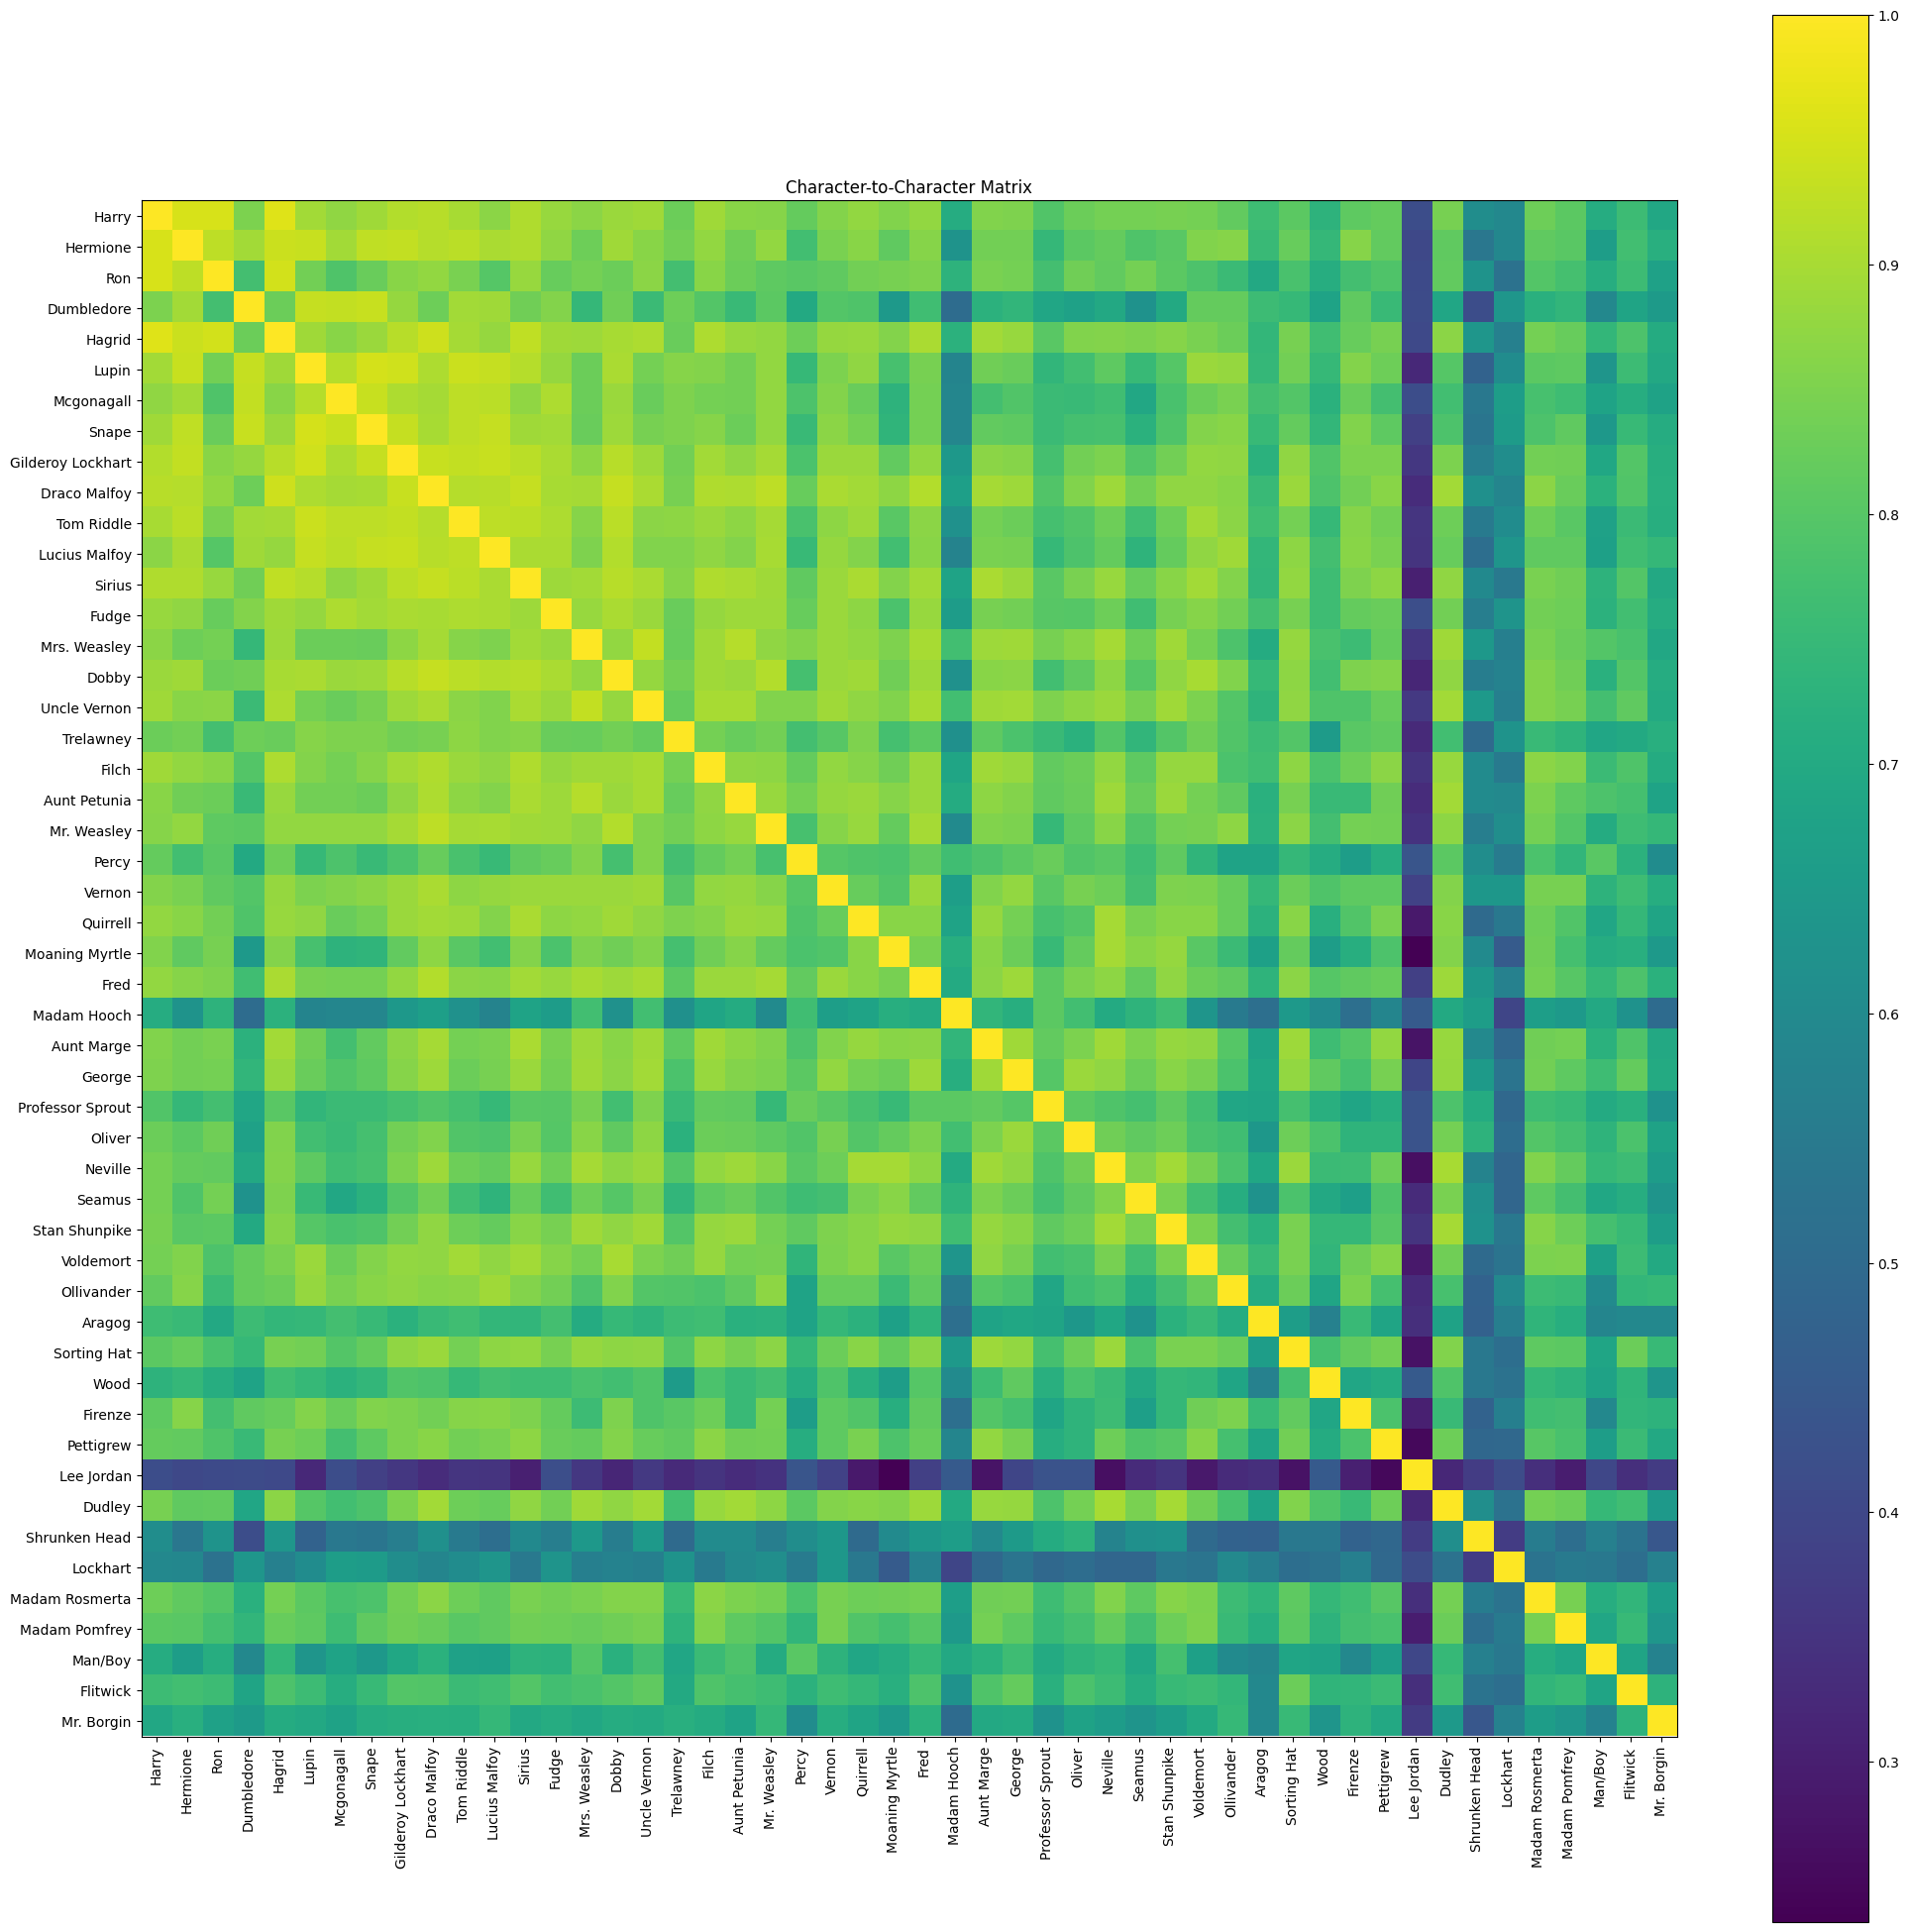

In [106]:
#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences_50_most_vocabulary['Character'], histword_similarity_df)

In [111]:
# Task 7, 8 ,9

#7 Construct a global vocabulary by integrating the vocabulary of each character.
# Create a DataFrame from the split data
df = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()

# Tokenize and preprocess the script text for each character
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    return [token for token in tokens if token.isalnum()]  # Keeps only alphanumeric tokens

# Create a dictionary to store the vocabularies for each character
character_vocabs = {}

# Create a global vocabulary set
global_vocab = set()

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    character = row['Character']
    script = row['Sentence']
    
    # Tokenize and preprocess the script text
    tokens = preprocess_text(script)
    
    # Create a vocabulary set for the current character
    character_vocab = set(tokens)
    
    # Merge the character's vocabulary into the global vocabulary
    global_vocab.update(character_vocab)
    
    # Store the character's vocabulary in the dictionary
    character_vocabs[character] = character_vocab

# Print the global vocabulary
print("Global Vocabulary:")
print(global_vocab)



Global Vocabulary:
{'occur', 'product', 'much', 'fudge', 'change', 'leads', 'mouth', 'heart', 'grand', 'however', 'page', 'funny', 'beast', 'ernie', 'gambling', 'already', 'christmas', 'speak', 'investigate', 'deep', 'running', 'malfoy', 'great', 'indeed', 'late', 'made', 'lord', 'trouble', 'meanwhile', 'treat', 'fat', 'potter', 'school', 'sacrifice', 'linger', 'bitten', 'sensed', 'girl', 'finish', 'brightest', 'gifted', 'right', 'prior', 'flesh', 'dare', 'miss', 'furious', 'alive', 'well', 'many', 'happy', 'asking', 'fired', 'owe', 'slope', 'astronomy', 'realized', 'spoken', 'somebody', 'facts', 'parents', 'strutting', 'tough', 'notice', 'slip', 'lumos', 'hedwig', 'sold', 'wander', 'hands', 'told', 'beauty', 'allowed', 'friend', 'clipping', 'half', 'runes', 'dreams', 'peaky', 'quarters', 'obvious', 'diary', 'rosmerta', 'freed', 'slowly', 'fell', 'sweetshop', 'stationed', 'green', 'places', 'fortunately', 'beyond', 'done', 'dufftown', 'detect', 'meaningless', 'truly', 'clean', 'escape'

In [113]:
#7 Write a script using tf-idf vectorizer of Gensim to provide a vector representation of each corpus 

# Group script text by character
character_scripts = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()

# Tokenize and preprocess the script for each character
character_scripts['Preprocessed_Script'] = character_scripts['Sentence'].apply(preprocess_text)

# Create a dictionary for the scripts
dictionary = corpora.Dictionary(character_scripts['Preprocessed_Script'])

# Create a corpus for the scripts
corpus = [dictionary.doc2bow(text) for text in character_scripts['Preprocessed_Script']]

# Create a TF-IDF model from the corpus
tfidf = gensim.models.TfidfModel(corpus)

# Calculate TF-IDF vectors for each character's script
tfidf_vectors = [tfidf[doc] for doc in corpus]

# Print the TF-IDF vectors for each character
for idx, character in enumerate(character_scripts['Character']):
    print(f"TF-IDF vector for {character}:")
    print(tfidf_vectors[idx])

TF-IDF vector for All:
[(0, 0.37421675517273334), (1, 0.2944970486645707), (2, 0.5456667473896534), (3, 0.19709120992007984), (4, 0.17625223291032502), (5, 0.329320944711154), (6, 0.3577741395422412), (7, 0.20276676295581317), (8, 0.3577741395422412)]
TF-IDF vector for Aragog:
[(3, 0.06587539868434741), (9, 0.18238263668714882), (10, 0.1462271277456024), (11, 0.09843214469082091), (12, 0.2201432376081119), (13, 0.18238263668714882), (14, 0.09506572678780263), (15, 0.18238263668714882), (16, 0.18238263668714882), (17, 0.08892200187876283), (18, 0.1250775108203093), (19, 0.0784547427921327), (20, 0.15573727055766048), (21, 0.18238263668714882), (22, 0.11958176161611406), (23, 0.18238263668714882), (24, 0.18238263668714882), (25, 0.11461025173367914), (26, 0.06777238495346971), (27, 0.0834262526745676), (28, 0.2201432376081119), (29, 0.18238263668714882), (30, 0.1462271277456024), (31, 0.18238263668714882), (32, 0.1381864165674403), (33, 0.1312212357293491), (34, 0.18238263668714882), (35

In [115]:


#7 use the cosine similarity to calculate the similarity between two characters. Write down the new similarity matrix.

# Convert TF-IDF vectors to a format compatible with softcossim
tfidf_matrix = gensim.matutils.corpus2csc(tfidf_vectors)

# Calculate cosine similarity between character TF-IDF vectors
cosine_similarity_matrix = cosine_similarity(tfidf_matrix.T, tfidf_matrix.T)

# Create a DataFrame to represent the similarity matrix
character_names = character_scripts['Character']
similarity_df = pd.DataFrame(cosine_similarity_matrix, columns=character_names, index=character_names)

# Print the cosine similarity matrix
print("Cosine Similarity Matrix:")
print(similarity_df)



Cosine Similarity Matrix:
Character                   All    Aragog  Aunt Marge  Aunt Petunia  \
Character                                                             
All                    1.000000  0.012983    0.000000      0.025055   
Aragog                 0.012983  1.000000    0.051703      0.069439   
Aunt Marge             0.000000  0.051703    1.000000      0.322432   
Aunt Petunia           0.025055  0.069439    0.322432      1.000000   
Aunt Petunia & Dudley  0.000000  0.037539    0.000000      0.000000   
...                         ...       ...         ...           ...   
Voice                  0.065609  0.030082    0.032404      0.030707   
Voldemort              0.109724  0.007630    0.049535      0.046506   
Whispers               0.000000  0.000000    0.000000      0.000000   
Witch                  0.024202  0.066822    0.008531      0.023350   
Wood                   0.029733  0.058989    0.039294      0.075562   

Character              Aunt Petunia & Dudley  Bark

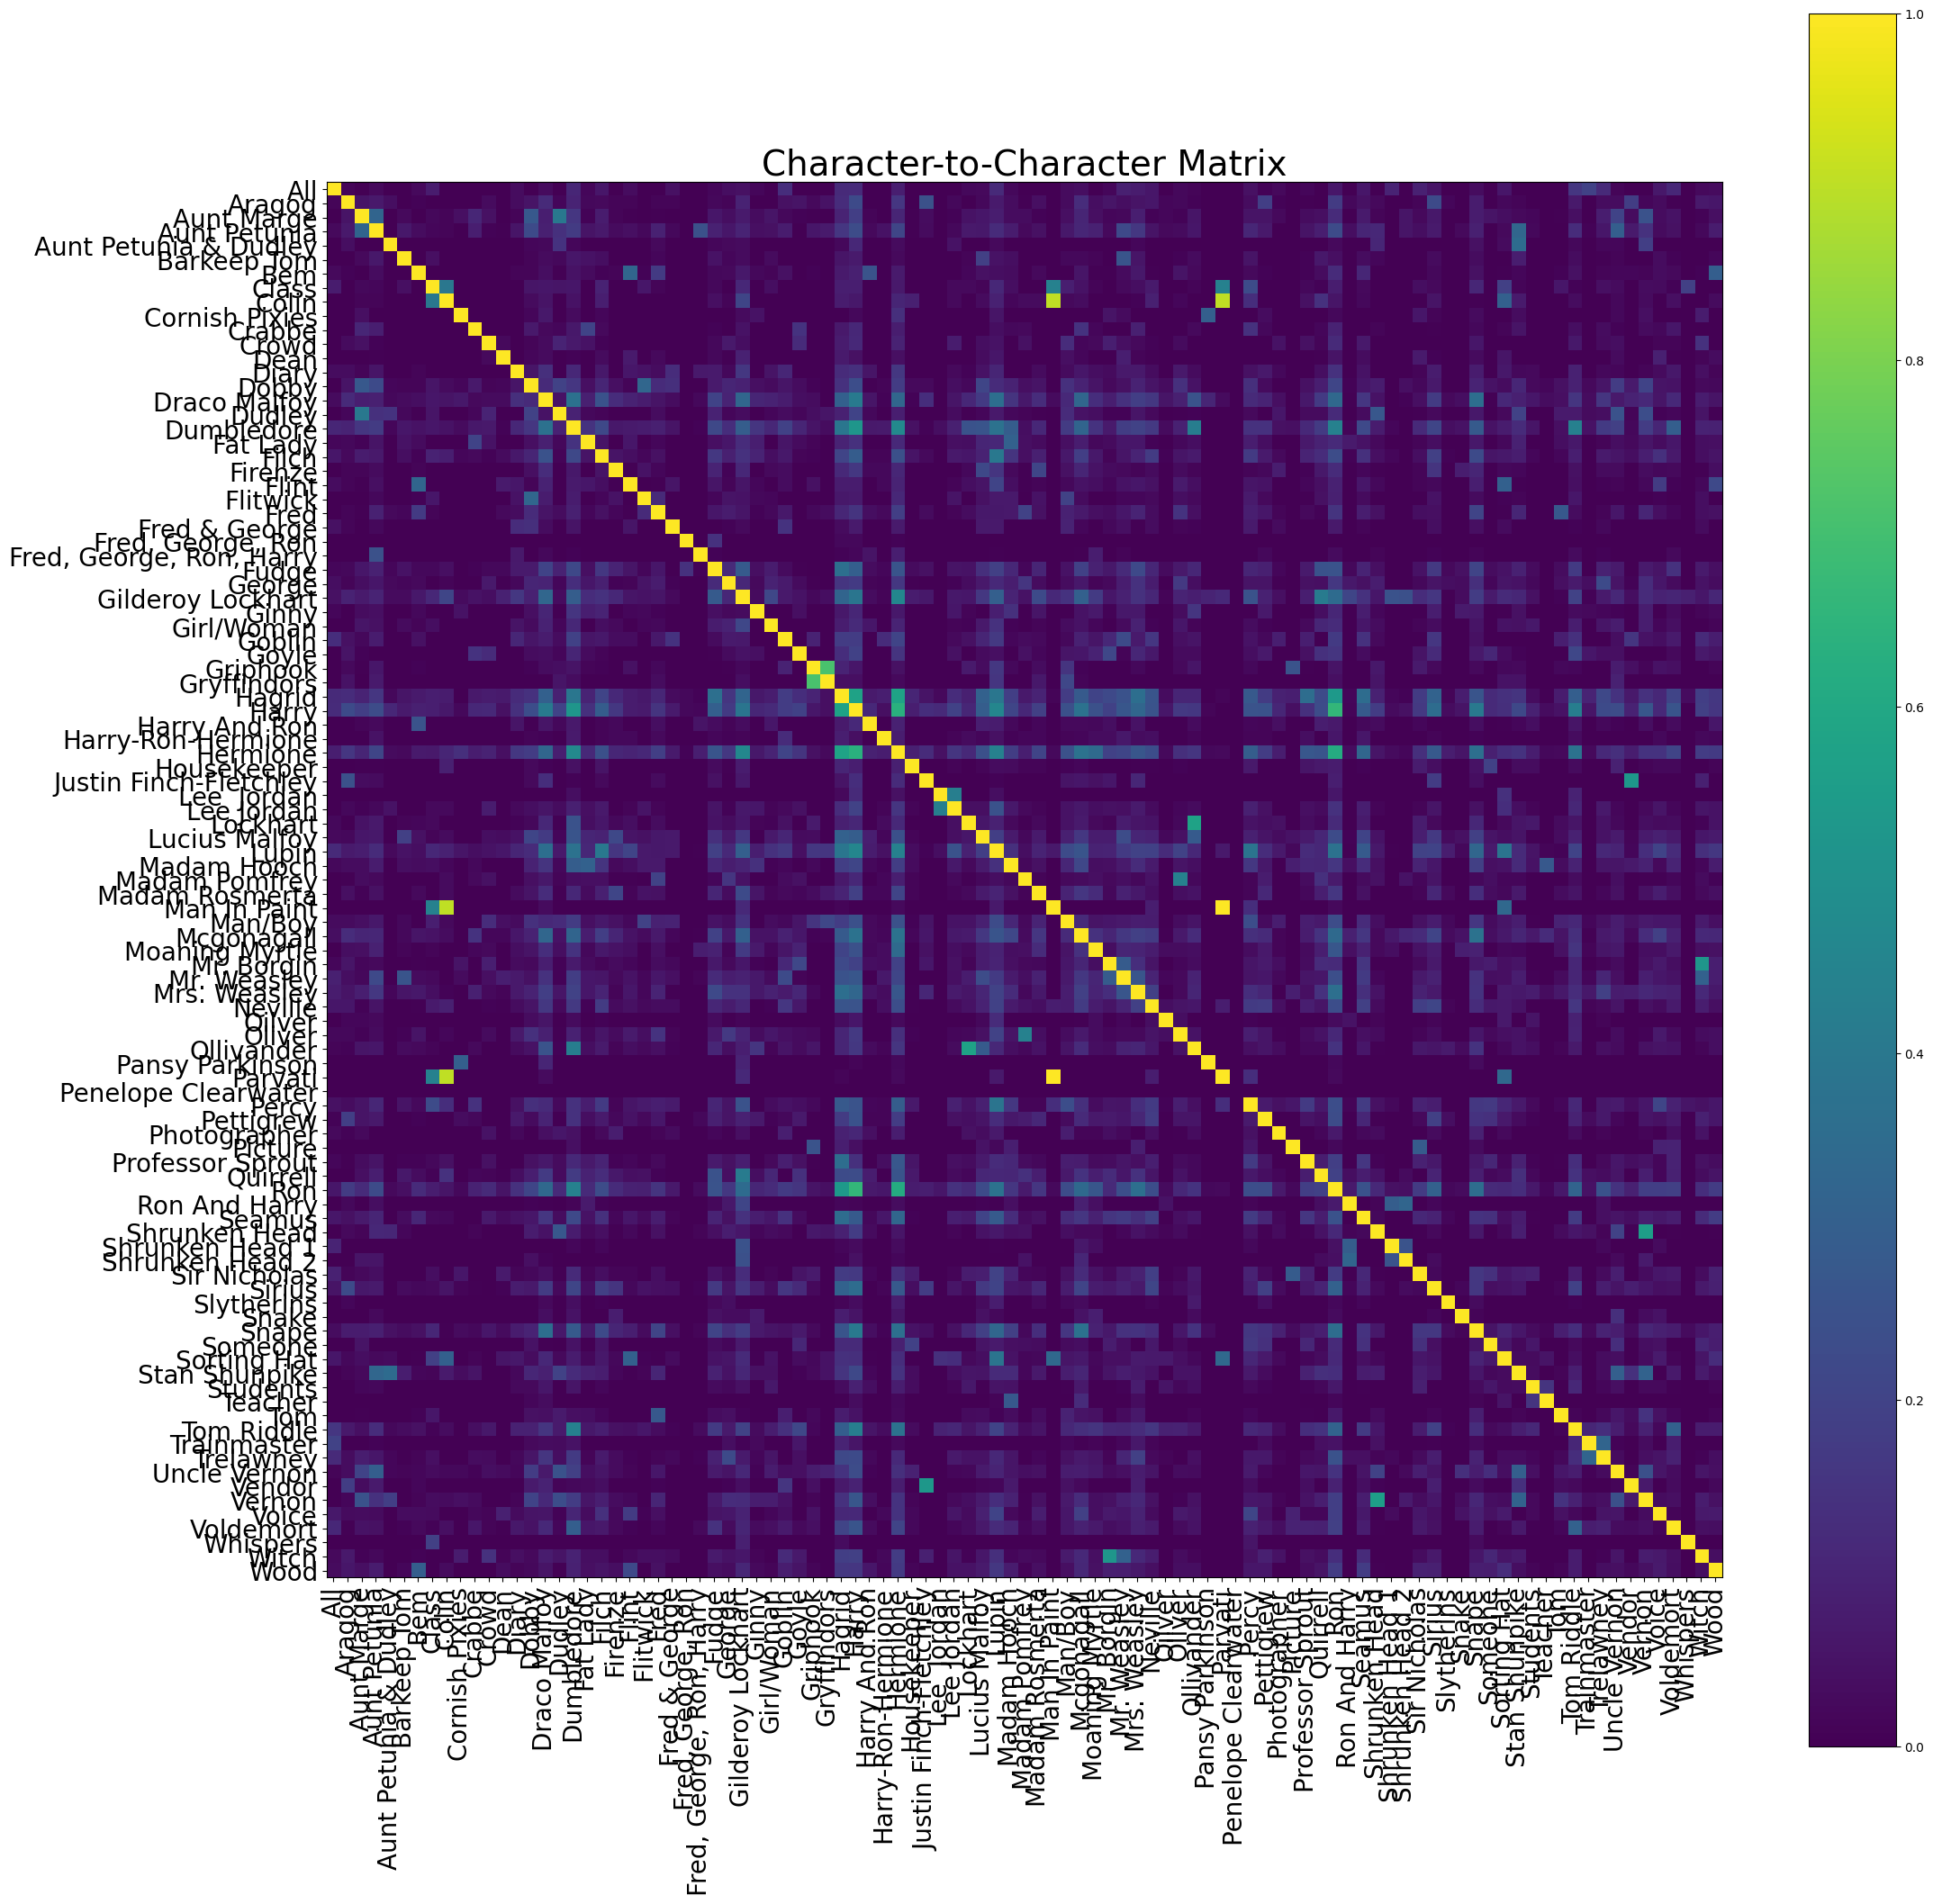

In [117]:
#Plot the matrix
CharacterToCharacterMatrixPlot(character_scripts['Character'], similarity_df)

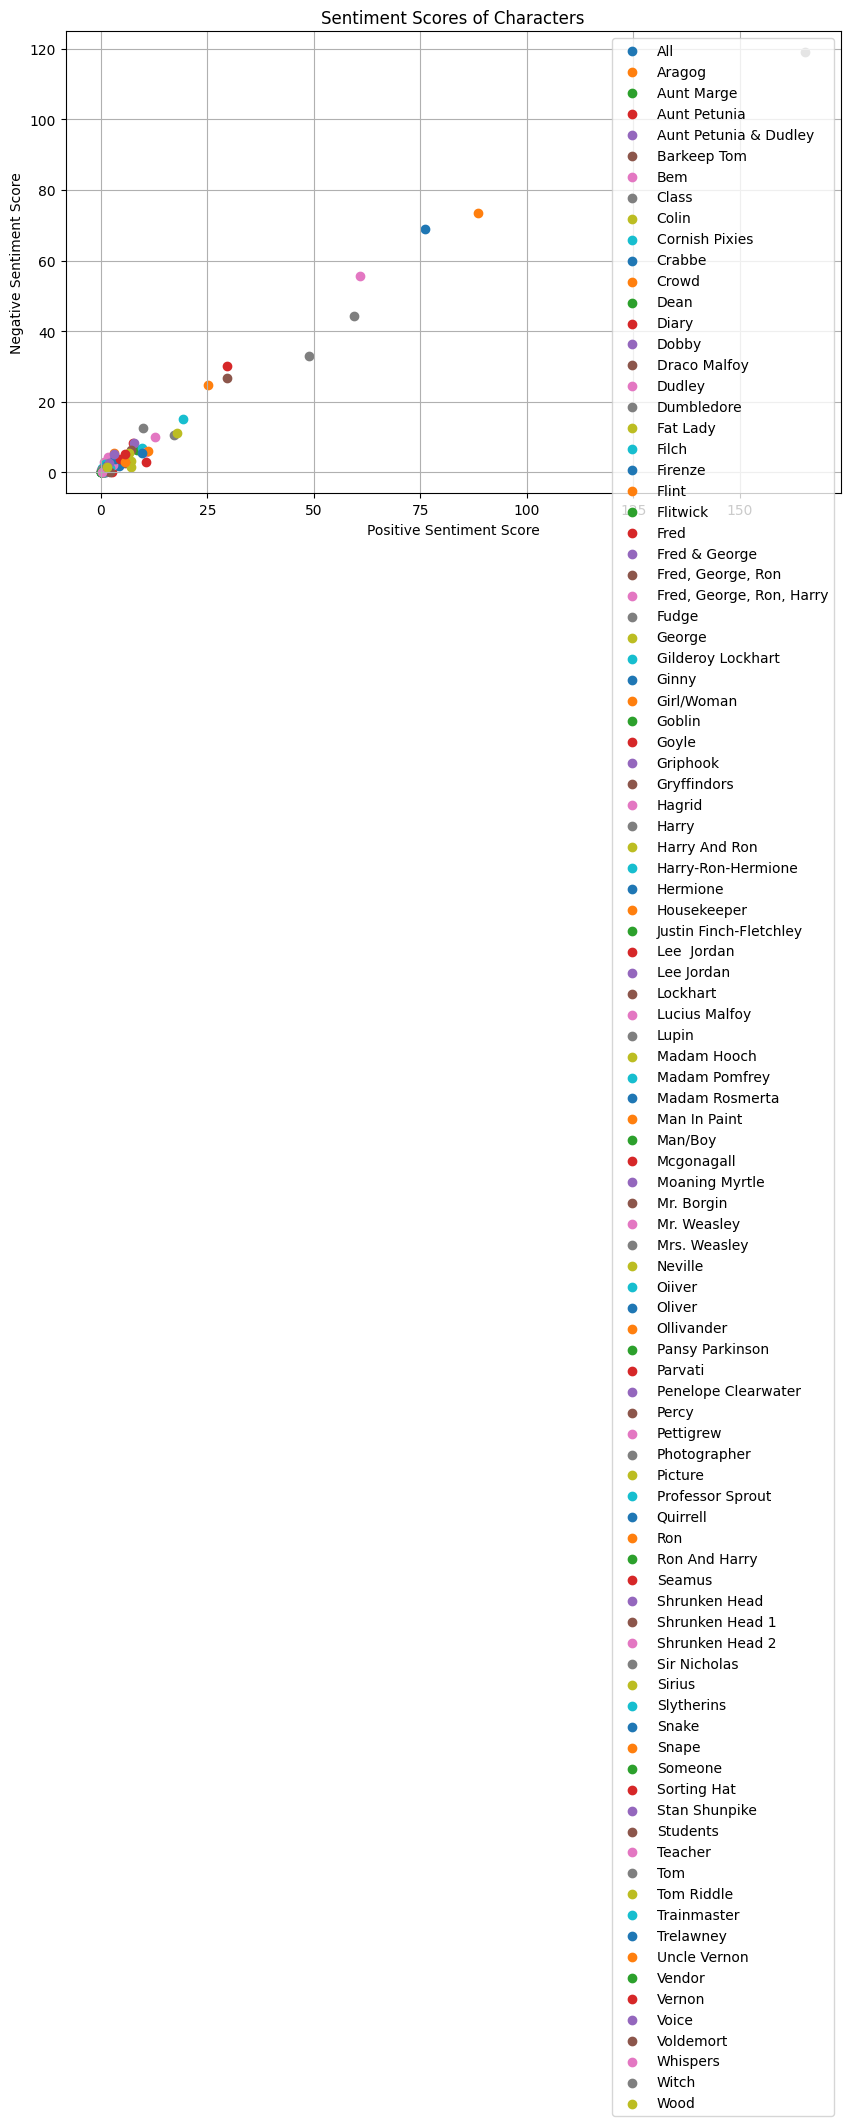

In [119]:
#8

# Group script text by character

character_scripts = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()
# Tokenize and preprocess the script for each character
character_scripts['Preprocessed_Script'] = character_scripts['Sentence'].apply(preprocess_text)

# Function to calculate sentiment score for a token
def get_sentiment_score(token):
    synsets = list(swn.senti_synsets(token))
    if synsets:
        # Take the first synset
        synset = synsets[0]
        return synset.pos_score(), synset.neg_score()
    else:
        return 0, 0

# Calculate sentiment scores for each character's script
character_sentiment_scores = []

for script in character_scripts['Preprocessed_Script']:
    positive_scores = []
    negative_scores = []
    
    for token in script:
        pos_score, neg_score = get_sentiment_score(token)
        positive_scores.append(pos_score)
        negative_scores.append(neg_score)
    
    # Aggregate sentiment scores for the script
    total_positive_score = sum(positive_scores)
    total_negative_score = sum(negative_scores)
    
    character_sentiment_scores.append((total_positive_score, total_negative_score))

# Create a scatter plot of sentiment scores
plt.figure(figsize=(10, 6))

for i, character in enumerate(character_scripts['Character']):
    x, y = character_sentiment_scores[i]
    plt.scatter(x, y, label=character, marker='o')

plt.xlabel('Positive Sentiment Score')
plt.ylabel('Negative Sentiment Score')
plt.title('Sentiment Scores of Characters')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Download and load the Word2Vec model
model = api.load("word2vec-google-news-300")

# Group script text by character
character_scripts = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()

# Tokenize and preprocess the script for each character
character_scripts['Preprocessed_Script'] = character_scripts['Sentence'].apply(preprocess_text)

# Function to calculate the average Word2Vec embedding for a script
def calculate_average_embedding(tokens, model):
    embeddings = [model[token] for token in tokens if token in model.key_to_index]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Calculate average Word2Vec embeddings for each character's script
character_embeddings = []

for script_tokens in character_scripts['Preprocessed_Script']:
    character_embedding = calculate_average_embedding(script_tokens, model)
    character_embeddings.append(character_embedding)

# Calculate cosine similarity between character embeddings
similarity_matrix = cosine_similarity(character_embeddings)

# Create a DataFrame to represent the similarity matrix
character_names = character_scripts['Character']
similarity_df_word2vec = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)

[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=-------------------------------------------------] 3.3% 55.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==------------------------------------------------] 4.2% 70.5/1662.8MB downloaded

In [ ]:
#Plot the matrix
CharacterToCharacterMatrixPlot(character_scripts['Character'], similarity_df_word2vec)